In [1]:
import warnings
import re
import emoji
import MeCab
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pprint import pprint
from tqdm.notebook import tqdm
from collections import Counter
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

import tensorflow as tf
import keras.backend as K
from keras import regularizers
from keras.models import Sequential
from keras.models import Model
from keras.layers import Input
from keras.layers import InputLayer
from keras.layers import Embedding
from keras.layers import Dense
from keras.layers import Add
from keras.layers import Concatenate
from keras.layers import ZeroPadding1D
from keras.layers import Dropout
from keras.layers import SpatialDropout1D
from keras.layers import Activation
from keras.layers import Conv1D
from keras.layers import MaxPooling1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPool1D
from keras.layers import AveragePooling1D
from keras.layers import BatchNormalization
from keras.layers import Flatten
from keras.layers import SimpleRNN
from keras.layers import CuDNNLSTM
from keras.layers import Bidirectional
from keras.layers.recurrent import LSTM
from keras.layers.recurrent import GRU
from keras.optimizers import Optimizer
from keras.optimizers import Adam
from keras.optimizers import SGD
from keras.optimizers import Adagrad
from keras.optimizers import Adadelta
from keras.optimizers import RMSprop
from keras.optimizers import Nadam
from keras.layers.normalization import BatchNormalization
from keras.preprocessing import text
from keras.preprocessing import sequence
from keras.callbacks import EarlyStopping
from keras.callbacks import ModelCheckpoint
from keras.callbacks import ReduceLROnPlateau
from keras.callbacks import TensorBoard
from gensim.models.word2vec import Word2Vec

warnings.filterwarnings("ignore")
plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
# Input parameters
config = {
    # Text parameters
    "MAX_FEATURE": 10000, 
    "MAX_LEN": 64, 
    "EMBED_SIZE": 300, 

    # Convolution parameters
    "filter_length": 3, 
    "nb_filter": 150, 
    "pool_length": 2, 
    "cnn_activation": 'relu', 
    "border_mode": 'same', 

    # RNN parameters
    "lstm_cell": 128, 
    "output_size": 50, 
    "rnn_activation": 'tanh', 
    "recurrent_activation": 'hard_sigmoid', 
    
    # FC and Dropout
    "fc_cell": 128, 
    "dropout_rate": 0.25, 

    # Compile parameters
    "loss": 'binary_crossentropy', 
    "optimizer": 'adam', 

    # Training parameters
    "batch_size": 256, 
    "nb_epoch": 500, 
    "validation_split": 0.50, 
    "shuffle": True
}

In [3]:
df = pd.read_csv(r"C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\data\all_20200423.csv")
# create the label
df["label"] = df["rating"].apply(lambda x: 0 if int(x) <= 3 else 1)
# select only relevant columns
df = df[["content", "label"]]
df["content"] = df["content"].map(str)
df.sample(5)

content  label
8940               バックでつかえて検索結果をMIXで選んだらその人の全曲が出るので使い易い      1
8957  やっと見つけた！Androidでいいのあんまなかった所、ダメ元に入れてみたらまさかの素晴らし...      1
4234                             思ってたより全然曲ない星野源が変なのしかない      0
2947                                               便利です      1
6576                                            🐼🐥🐓🐥 、り      0

In [4]:
df["length"] = df["content"].map(len)
text_len = df["length"].values
max_len = text_len.max()

len_sum = [0] * max_len
for i in text_len:
    len_sum[i-1] += 1
    
len_cum = [len_sum[0]] + [0] * (max_len-1)
for i in range(1, max_len):
    len_cum[i] += len_sum[i] + len_cum[i-1]

print('Cumulative %   # Words  # Comments')
for i in range(max_len):
    len_cum[i] /= len(text_len)
    if len_sum[i] != 0:
        if (len_cum[i] >= 0.8 and len_cum[i-1] < 0.8):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.85 and len_cum[i-1] < 0.85):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.9 and len_cum[i-1] < 0.9):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.92 and len_cum[i-1] < 0.92):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))
        if (len_cum[i] >= 0.95 and len_cum[i-1] < 0.95):
            print(' %.5f   \t  %d \t    %d'%(len_cum[i]*100, i, len_sum[i]))

Cumulative %   # Words  # Comments
 80.14077   	  55 	    84
 85.21870   	  68 	    46
 90.21044   	  86 	    36
 92.06349   	  96 	    21
 95.07290   	  118 	    14


In [5]:
def create_mecab_list(text):
    pos_list = [10, 11, 31, 32, 34]
    pos_list.extend(list(range(36,50)))
    pos_list.extend([59, 60, 62, 67])

    mecab_list = []
    mecab = MeCab.Tagger("-Owakati")
    mecab.parse("")
    # encoding = text.encode('utf-8')
    node = mecab.parseToNode(text)
    while node:
        if len(node.surface) > 1:
            if node.posid in pos_list:
                morpheme = node.surface
                mecab_list.append(morpheme)
        node = node.next
    return mecab_list

def give_emoji_free_text(text):
    allchars = [string for string in text]
    emoji_list = [c for c in allchars if c in emoji.UNICODE_EMOJI]
    cleaned_text = ' '.join([str for str in text.split() if not any(i in str for i in emoji_list)])
    return cleaned_text

def clean_text(text):
    # Remove emoji
    text = give_emoji_free_text(text)
    # Remove punctuation
    text = re.sub(r'[^\w\d\s]+', '', text)
    # Remove digits
    text = ''.join([i for i in text if not i.isdigit()]) 
    # Tokenize the sentence
    tokenised_text_list = create_mecab_list(text)
    return tokenised_text_list

def create_word2index_and_index2word(df):
    df["cleaned_text"] = df["content"].apply(clean_text)
    sum_list = []
    for index, row in df.iterrows():
        sum_list += row["cleaned_text"]

    word2index = dict()
    index2word = dict()
    num_words = 0
    for word in sum_list:
        if word not in word2index:
            # First entry of word into vocabulary
            word2index[word] = num_words
            index2word[num_words] = word
            num_words += 1
    
    return word2index, index2word

def convert_tokens_to_ids(tokens_list, word2index):
    ids_list = []
    for token in tokens_list:
        if word2index.get(token, None) != None:
            ids_list.append(word2index[token])
    return ids_list

def remove_empty_ids_rows(df):
    empty = (df['ids'].map(len) == 0)
    return df[~empty]

In [6]:
word2index, index2word = create_word2index_and_index2word(df)
df["ids"] = df["content"].apply(lambda x: convert_tokens_to_ids(clean_text(x), word2index))
df = remove_empty_ids_rows(df)
df.head()

content  label  length  \
0  アプリをダウンロードしたばかりで、バックグラウンドで聴いています。星の理由は曲のダウンロード...      0     211   
1                                                nan      1       3   
2  ダウンロードはネットが必要ですが、その後はオフラインで聞くことが出来てとても便利です。 オフ...      1     172   
3  広告をあまり見たくない方は、下のタブにある本人→右上のアイコンを押すと、30秒間の広告を見る...      1     124   
4  音楽をダウンロードしようと思ったら、ダウンロードマークが無くて、追加しかない状態だった。その...      0     121   

                                        cleaned_text  \
0  [アプリ, ダウンロード, バックグラウンド, 聴い, 理由, ダウンロード, 出来, 聴い...   
1                                              [nan]   
2  [ダウンロード, ネット, 必要, その後, オフライン, 聞く, 出来, 便利, オフライ...   
3  [広告, タブ, ある, 本人, アイコ, 押す, 広告, 見る, 代わり, 時間, 広告,...   
4  [音楽, ダウンロード, しよ, 思っ, ダウンロード, マーク, 無く, 追加, ない, ...   

                                                 ids  
0  [0, 1, 2, 3, 4, 1, 5, 3, 6, 7, 8, 9, 10, 11, 1...  
1                                               [26]  
2  [1, 27, 28, 29, 30, 31, 5, 32, 30, 33, 34, 35,...  
3  [14, 42, 43, 44, 45, 46, 14, 47, 48, 49, 14, 5...  
4  [15, 1, 62, 63, 1, 64, 65, 35, 66, 67, 68, 69,...

In [7]:
x = df["ids"].map(lambda x: np.array(x))
x = sequence.pad_sequences(x, maxlen=config["MAX_LEN"], padding="post")
print("Features: \n", x)
y = df["label"].values
print("Labels: \n", y)

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=17)

Features: 
 [[   0    1    2 ...    0    0    0]
 [  26    0    0 ...    0    0    0]
 [   1   27   28 ...    0    0    0]
 ...
 [ 531    0    0 ...    0    0    0]
 [ 284    0    0 ...    0    0    0]
 [7503    0    0 ...    0    0    0]]
Labels: 
 [0 1 1 ... 1 1 1]


In [8]:
def get_embedding_index(model_path):
    w2v = Word2Vec.load(model_path)
    embedding_index = {}
    for word in w2v.wv.vocab:
        embedding_index[word] = w2v.wv.word_vec(word)
    print('Loaded {} word vectors.'.format(len(embedding_index)))

    return embedding_index

def get_embedding_matrix(word2index, embeddings_index, embed_size):
    embedding_matrix = np.zeros((len(word2index) + 1, embed_size))
    for word, i in word2index.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            # words found in embedding index will be pretrained vectors.
            embedding_matrix[i+1] = embedding_vector
        else:
            # words not found in embedding index will be random vectors with certain mean&std.
            embedding_matrix[i+1] = np.random.normal(0.053, 0.3146, size=(1, embed_size))[0]

    # save embedding matrix
    # embed_df = pd.DataFrame(embedding_matrix)
    # embed_df.to_csv(self.path_embedding_matrix, header=None, sep=' ')

    return embedding_matrix

In [9]:
embedding_index = get_embedding_index(r'F:\embedding_file\word2vec\ja.bin')
embedding_matrix = get_embedding_matrix(word2index, embedding_index, embed_size=300)

Loaded 50108 word vectors.


In [10]:
def get_f1(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val

In [11]:
# Reference from https://medium.com/@mlguy/adding-custom-loss-and-optimizer-in-keras-e255764e1b7d
class COCOB(Optimizer):
    """Coin Betting Optimizer from the paper:
        https://arxiv.org/pdf/1705.07795.pdf
    """
    def __init__(self, alpha=100, **kwargs):
        """
        Initialize COCOB Optimizer
        Args:
            alpha: Refer to paper.
        """
        super(COCOB, self).__init__(**kwargs)
        self._alpha = alpha
        with K.name_scope(self.__class__.__name__):
            self.iterations = K.variable(0, dtype='int64', name='iterations')
    def get_updates(self, params, loss, contraints=None):
        self.updates = [K.update_add(self.iterations, 1)]
        grads = self.get_gradients(loss, params)
        shapes = [K.int_shape(p) for p in params]
        L = [K.variable(np.full(fill_value=1e-8, shape=shape)) for shape in shapes]
        reward = [K.zeros(shape) for shape in shapes]
        tilde_w = [K.zeros(shape) for shape in shapes]
        gradients_sum = [K.zeros(shape) for shape in shapes]
        gradients_norm_sum = [K.zeros(shape) for shape in shapes]
        for p, g, li, ri, twi, gsi, gns in zip(params, grads, L, reward,
                                                     tilde_w,gradients_sum,
                                                       gradients_norm_sum):
            grad_sum_update = gsi + g
            grad_norm_sum_update = gns + K.abs(g)
            l_update = K.maximum(li, K.abs(g))
            reward_update = K.maximum(ri - g * twi, 0)
            new_w = - grad_sum_update / (l_update * (K.maximum(grad_norm_sum_update + l_update, self._alpha * l_update))) * (reward_update + l_update)
            param_update = p - twi + new_w
            tilde_w_update = new_w
            self.updates.append(K.update(gsi, grad_sum_update))
            self.updates.append(K.update(gns, grad_norm_sum_update))
            self.updates.append(K.update(li, l_update))
            self.updates.append(K.update(ri, reward_update))
            self.updates.append(K.update(p, param_update))
            self.updates.append(K.update(twi, tilde_w_update))
        return self.updates
    def get_config(self):
        config = {'alpha': float(K.get_value(self._alpha)) }
        base_config = super(COCOB, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))

In [12]:
def plot_history(history):
    # plot results
    loss = history.history['loss']
    val_loss = history.history['val_loss']

    f1 = history.history['get_f1']
    val_f1 = history.history['val_get_f1']

    plt.figure(figsize=(20,10))
    plt.subplot(2,1,1)
    plt.title('Loss')
    epochs = len(loss)
    plt.plot(range(epochs), loss, marker='.', label='loss')
    plt.plot(range(epochs), val_loss, marker='.', label='val_loss')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('loss')

    plt.subplot(2,1,2)
    plt.title('F1 Score')
    plt.plot(range(epochs), f1, marker='.', label='f1')
    plt.plot(range(epochs), val_f1, marker='.', label='val_f1')
    plt.legend(loc='best')
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(5)
    ax.spines['top'].set_linewidth(5)
    ax.spines['right'].set_linewidth(5)
    ax.spines['left'].set_linewidth(5)
    ax.set_facecolor('snow')
    plt.grid(color='lightgray', linestyle='-', linewidth=1)
    plt.xlabel('epoch')
    plt.ylabel('f1')
    plt.show()

In [13]:
def train_simple_rnn(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = SimpleRNN(units=config["output_size"], activation=config["rnn_activation"])(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training Simple RNN", "="*20)

    path = 'weights\{}_weights.hdf5'.format("rnn")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [14]:
def train_gru(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = GRU(units=config["output_size"], return_sequences=False)(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training GRU", "="*20)

    path = 'weights\{}_weights.hdf5'.format("gru")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [15]:
def train_lstm(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=False)(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training LSTM", "="*20)

    path = 'weights\{}_weights.hdf5'.format("lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [16]:
def train_bilstm(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = Bidirectional(LSTM(units=config['output_size'], return_sequences=True))(x)
    x = Bidirectional(LSTM(units=config['output_size'], return_sequences=False))(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(config['fc_cell'])(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training BiLSTM", "="*20)

    path = 'weights\weights.hdf5'
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [17]:
# Yoon Kim's paper: Convolutional Neural Networks for Sentence Classification
# Reference from https://www.aclweb.org/anthology/D14-1181.pdf
def train_cnn_static(x_train, y_train, wv_matrix, trainable=False):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=trainable)(x_input)
    
    x_conv_1 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=3, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(3))(x)
    x_conv_1 = BatchNormalization()(x_conv_1)
    x_conv_1 = Activation("relu")(x_conv_1)
    x_conv_1 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_1)
    
    x_conv_2 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=4, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(3))(x)
    x_conv_2 = BatchNormalization()(x_conv_2)
    x_conv_2 = Activation("relu")(x_conv_2)
    x_conv_2 = MaxPooling1D(pool_size=(config["MAX_LEN"]-4+1), strides=1, padding="valid")(x_conv_2)
    
    x_conv_3 = Conv1D(filters=config['nb_filter'], 
                      kernel_size=5, 
                      padding=config['border_mode'], 
                      kernel_regularizer=regularizers.l2(3))(x)
    x_conv_3 = BatchNormalization()(x_conv_3)
    x_conv_3 = Activation("relu")(x_conv_3)
    x_conv_3 = MaxPooling1D(pool_size=(config["MAX_LEN"]-5+1), strides=1, padding="valid")(x_conv_3)
    
    main = Concatenate(axis=1)([x_conv_1, x_conv_2, x_conv_3])
    main = Flatten()(main)
    main = Dropout(config['dropout_rate'])(main)
    main = Dense(units=1)(main)
    main = Activation('sigmoid')(main)
    model = Model(inputs=x_input, outputs=main)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training CNN-static", "="*20)

    path = 'weights\{}_weights.hdf5'.format("lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [18]:
def train_cnn_multichannel(x_train, y_train, wv_matrix, trainable=False):
    tf.keras.backend.clear_session()
    
    # Channel 1
    x_input_1 = Input(shape=(config["MAX_LEN"], ))
    embedding_1 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_1)
    x_conv_1 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(3))(embedding_1)
    x_conv_1 = BatchNormalization()(x_conv_1)
    x_conv_1 = Activation("relu")(x_conv_1)
    x_conv_1 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_1)
    flat_1 = Flatten()(x_conv_1)
    
    # Channel 2
    x_input_2 = Input(shape=(config["MAX_LEN"], ))
    embedding_2 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_2)
    x_conv_2 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(3))(embedding_2)
    x_conv_2 = BatchNormalization()(x_conv_2)
    x_conv_2 = Activation("relu")(x_conv_2)
    x_conv_2 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_2)
    flat_2 = Flatten()(x_conv_2)
    
    # Channel 1
    x_input_3 = Input(shape=(config["MAX_LEN"], ))
    embedding_3 = Embedding(
        wv_matrix.shape[0], 
        wv_matrix.shape[1], 
        weights=[wv_matrix], 
        trainable=trainable)(x_input_3)
    x_conv_3 = Conv1D(
        filters=config['nb_filter'], 
        kernel_size=3, 
        padding=config['border_mode'], 
        kernel_regularizer=regularizers.l2(3))(embedding_3)
    x_conv_3 = BatchNormalization()(x_conv_3)
    x_conv_3 = Activation("relu")(x_conv_3)
    x_conv_3 = MaxPooling1D(pool_size=(config["MAX_LEN"]-3+1), strides=1, padding="valid")(x_conv_3)
    flat_3 = Flatten()(x_conv_3)
    
    main = Concatenate(axis=1)([flat_1, flat_2, flat_3])
    main = Dense(units=100)(main)
    main = Activation('relu')(main)
    main = Dropout(config['dropout_rate'])(main)
    main = Dense(units=1)(main)
    main = Activation('sigmoid')(main)
    model = Model(inputs=[x_input_1, x_input_2, x_input_3], outputs=main)

    model.compile(loss=config["loss"], optimizer=config["optimizer"], metrics=[get_f1])

    print("="*20, "Start Training CNN-multichannel", "="*20)

    path = 'weights\{}_weights.hdf5'.format("lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        [x_train, x_train, x_train], y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [19]:
def train_cnn_lstm(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(config['dropout_rate'])(x)
    x = Conv1D(filters=config['nb_filter'], kernel_size=config['filter_length'], padding=config['border_mode'])(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=config['pool_length'])(x)
    x = LSTM(units=config['lstm_cell'], return_sequences=False)(x)
    x = Dense(config['fc_cell']*2)(x)
    x = Dropout(config['dropout_rate'])(x)
    x = Dense(units=1)(x)
    x = Activation('sigmoid')(x)
    model = Model(inputs=x_input, outputs=x)

    model.compile(loss=config['loss'], optimizer=config['optimizer'], metrics=[get_f1])

    print("="*20, "Start Training CNN-LSTM", "="*20)

    path = 'weights\{}_weights.hdf5'.format("cnn_lstm")
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=0, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=10, min_lr=0.001)

    history = model.fit(
        x_train, y_train, 
        batch_size=config['batch_size'], 
        epochs=config['nb_epoch'], 
        validation_split=config['validation_split'], 
        shuffle=config['shuffle'], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [20]:
def identity_resnet_block(x, nb_filter):
    x_shortcut = x

    # First component of main path
    res_x = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Second component of main path
    res_x = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(res_x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Third component of main path
    res_x = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(res_x)
    res_x = BatchNormalization()(res_x)

    # Final Step: add shortcut value to the main path
    x = Add()([x_shortcut, res_x])
    output = Activation('relu')(x)
    return output

def convolutional_resnet_block(x, nb_filter):
    x_shortcut = x

    # First component of main path
    res_x = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Second component of main path
    res_x = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(res_x)
    res_x = BatchNormalization()(res_x)
    res_x = Activation("relu")(res_x)

    # Third component of main path
    res_x = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(res_x)
    res_x = BatchNormalization()(res_x)

    # Shortcut path
    x_shortcut = Conv1D(filters=nb_filter, kernel_size=2, strides=1, padding='same')(x_shortcut)
    x_shortcut = BatchNormalization()(x_shortcut)

    # Final Step: add shortcut value to the main path
    x = Add()([x_shortcut, res_x])
    output = Activation('relu')(x)
    return output

def train_text_resnet(x_train, y_train, wv_matrix):
    tf.keras.backend.clear_session()
    # Resnet for reviews of UtaPass and KKBOX
    x_input = Input(shape=(config["MAX_LEN"], ))
    x = Embedding(wv_matrix.shape[0], wv_matrix.shape[1], weights=[wv_matrix], trainable=False)(x_input)
    x = SpatialDropout1D(0.25)(x)

    # Stage 1
    x = Conv1D(filters=64, kernel_size=3, strides=2)(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = MaxPooling1D(pool_size=2)(x)
    # Stage 2
    x = convolutional_resnet_block(x, 64)
    x = identity_resnet_block(x, 64)
    x = identity_resnet_block(x, 64)
    # Stage 3
    x = convolutional_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    x = identity_resnet_block(x, 128)
    # Stage 4
    x = convolutional_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    x = identity_resnet_block(x, 256)
    # Stage 5
    x = convolutional_resnet_block(x, 512)
    x = identity_resnet_block(x, 512)
    x = identity_resnet_block(x, 512)
    # Average pool
    x = AveragePooling1D(pool_size = 1)(x)
    # Output layer
    x = Flatten()(x)

    x = Dense(units=1024, activation='relu')(x)
    x = Dropout(0.5)(x)
    x = Dense(units=1024, activation='relu')(x)
    x = Dense(units=1)(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=x_input, outputs=x)
    model.compile(loss=config["loss"],
                  optimizer=config["optimizer"],
                  metrics=[get_f1])
    
    print("="*20, "Start Training Text-ResNet", "="*20)
    
    path = r'C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\notebook\weights\text_resnet_weights.hdf5'
    # model_checkpoint = ModelCheckpoint(path, monitor='loss', verbose=1, save_best_only=True, mode='auto')
    early_stopping = EarlyStopping(monitor = 'loss', patience=100, verbose=1, mode='auto')
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=50, min_lr=0.001)
    
    history = model.fit(
        x_train, y_train, 
        batch_size=config["batch_size"], 
        epochs=config["nb_epoch"], 
        validation_split=config["validation_split"], 
        shuffle=config["shuffle"], 
        verbose=0, 
        callbacks=[early_stopping, reduce_lr])
    
    return history, model

In [21]:
def predict(sentences, model):
    y_prob = model.predict(x_test)
    y_prob = y_prob.squeeze()
    y_pred = (y_prob > 0.5) 
    return y_pred

In [22]:
adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False)
sgd = SGD(lr=0.01, momentum=0.0, decay=0.0, nesterov=False)
adagrad = Adagrad(learning_rate=0.01)
adadelta = Adadelta(learning_rate=1.0, rho=0.95)
rmsprop = RMSprop(learning_rate=0.001, rho=0.9)
nadam = Nadam(learning_rate=0.002, beta_1=0.9, beta_2=0.999)
cocob = COCOB()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


In [23]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_simple_rnn(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
==================== Start Training Simple RNN ====================

Confusion Matrix: 
 [[ 684  343]
 [ 400 1157]]
Training model using sgd.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 739  357]
 [ 345 1143]]
Training model using adagrad.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 733  359]
 [ 351 1141]]
Training model using adadelta.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 731  321]
 [ 353 1179]]
Training model using rmsprop.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 750  374]
 [ 334 1126]]
Training model using nadam.
==================== Start Training Simple RNN ====================
Confusion Matrix: 
 [[ 736  391]
 [ 348 1109]]
Training model using cocob.
===============

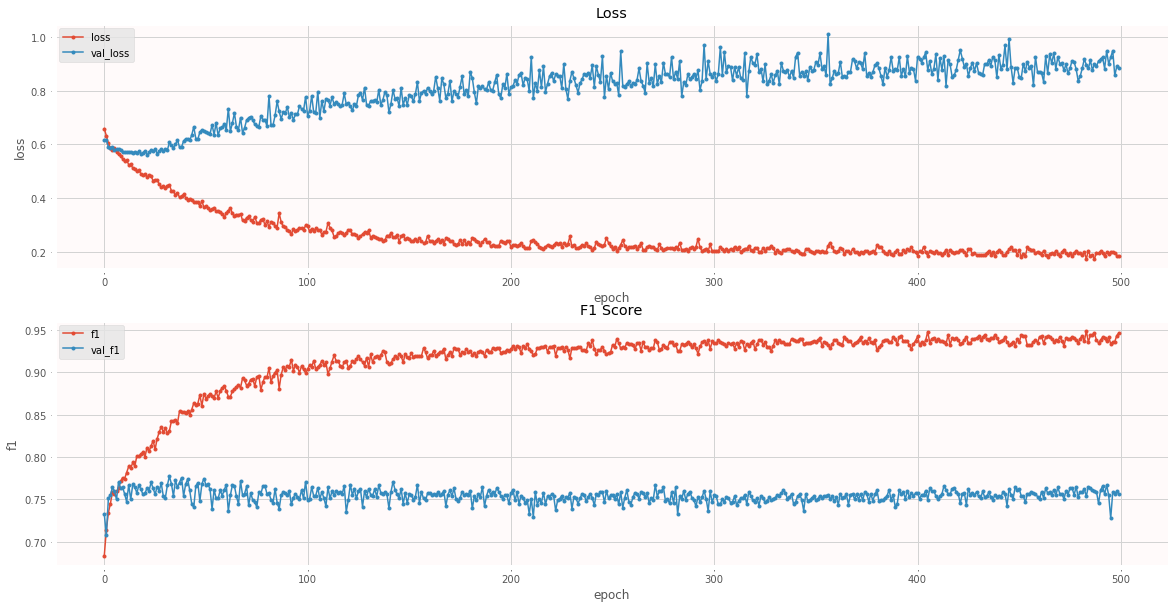

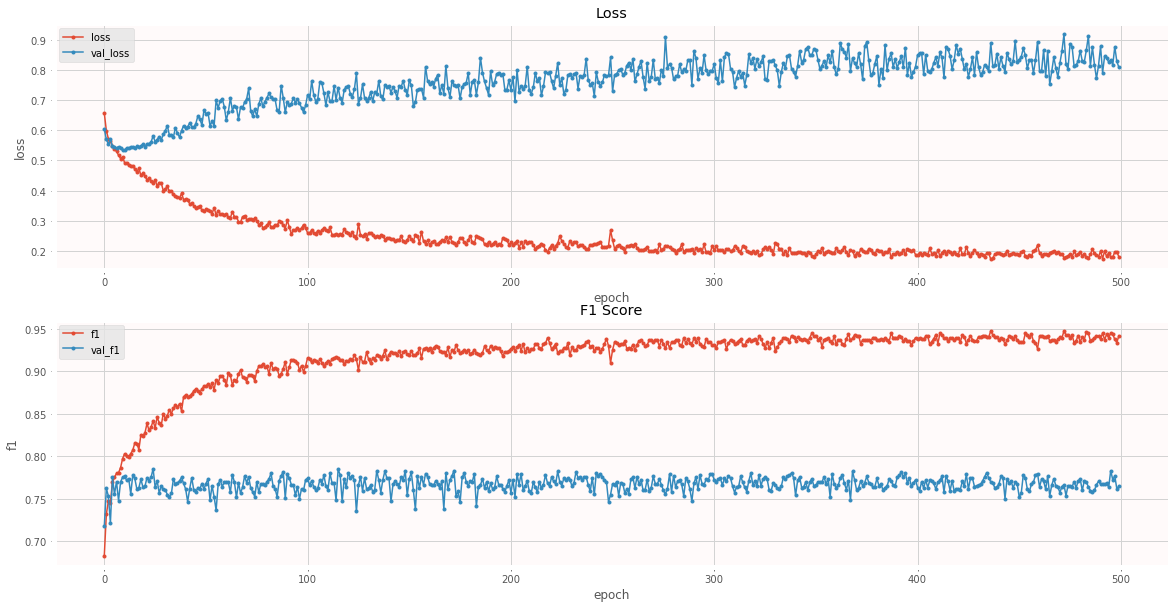

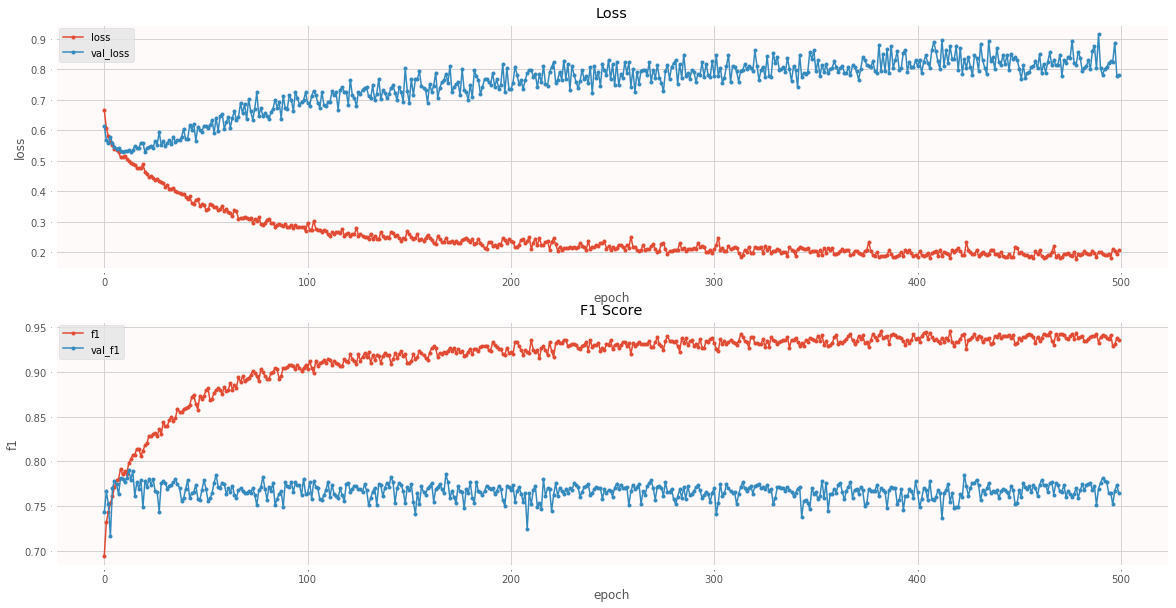

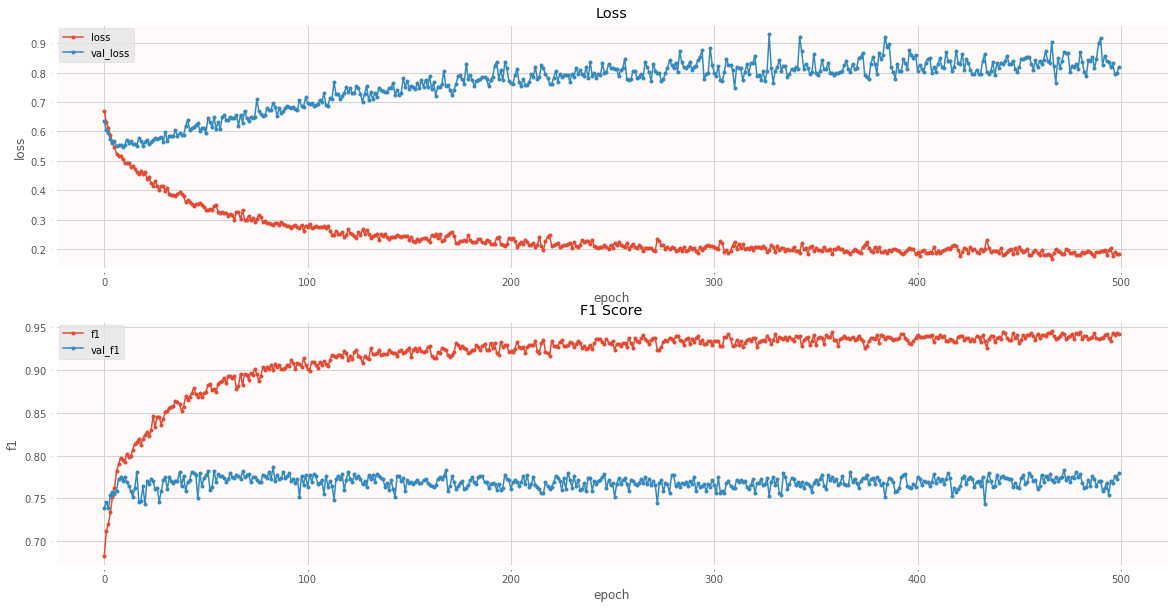

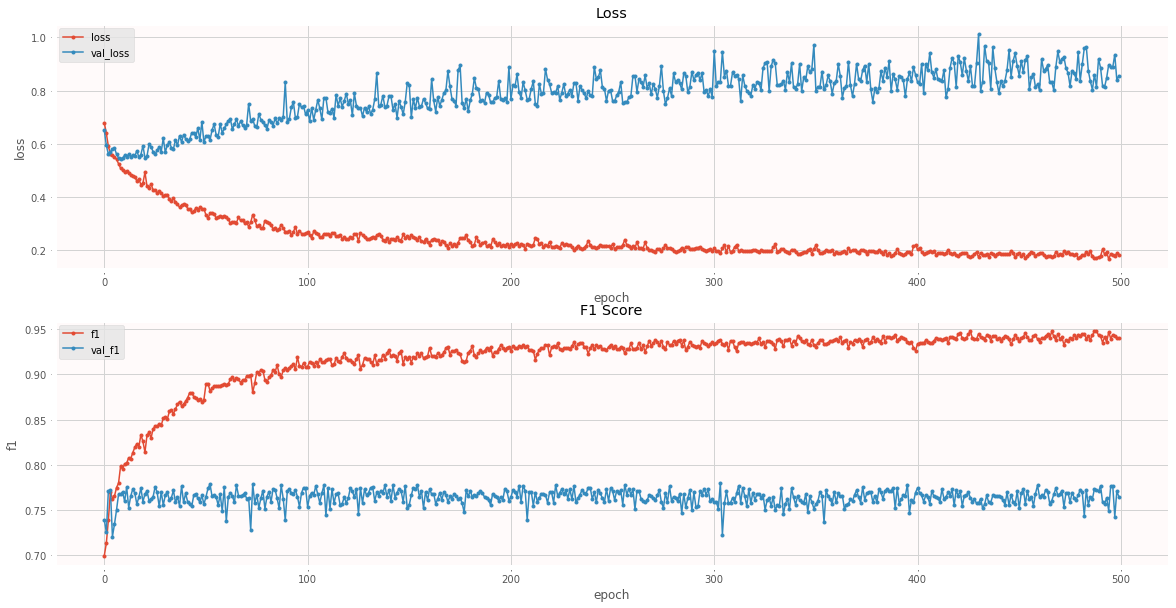

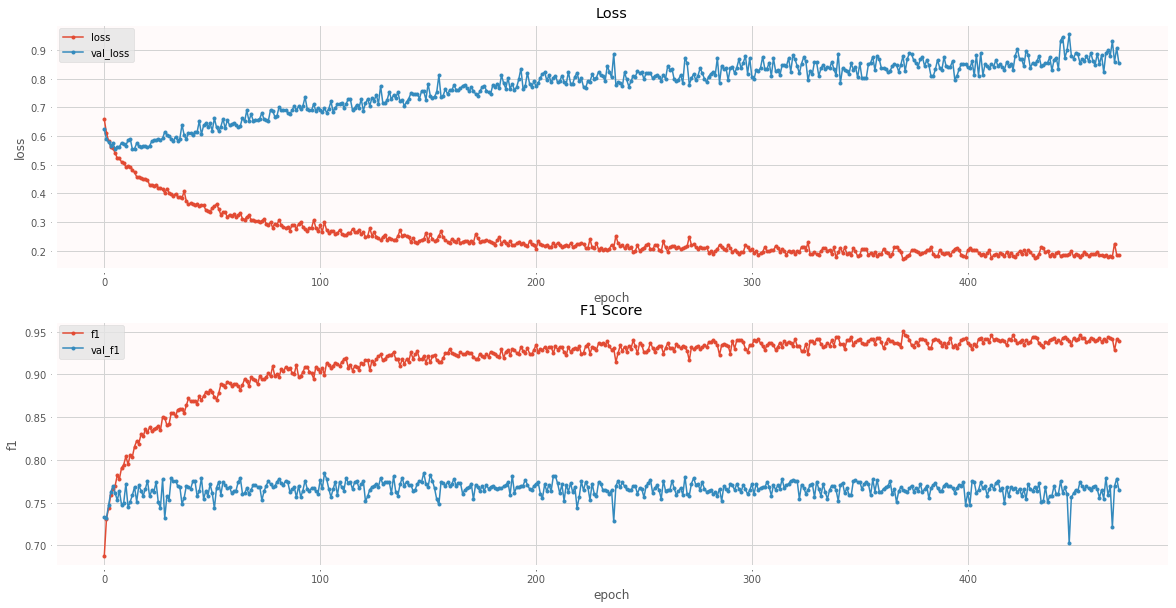

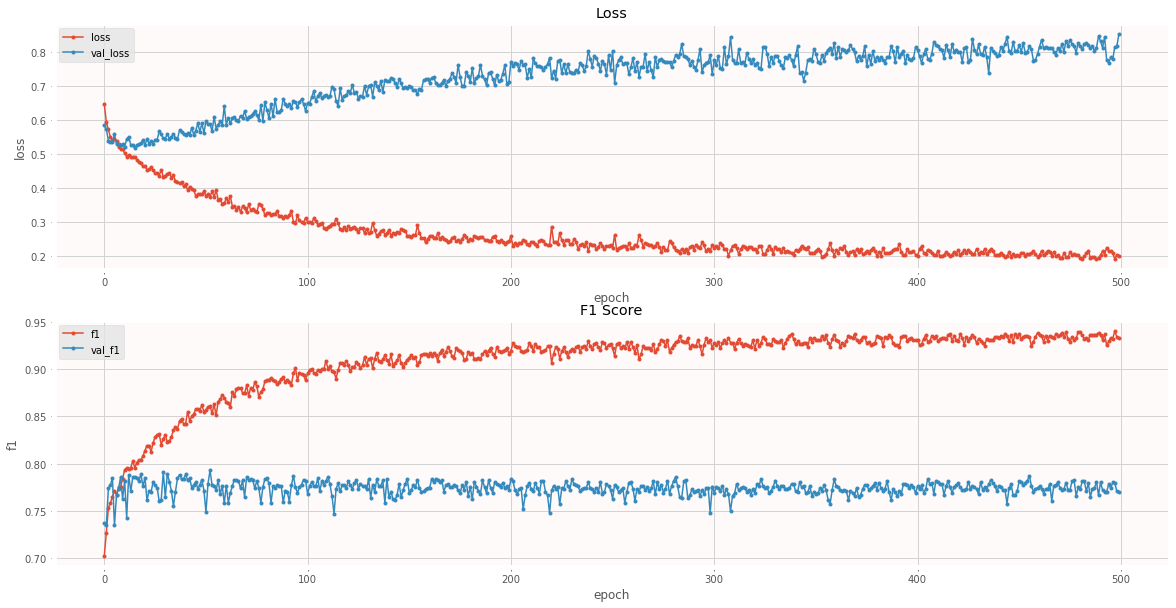

In [24]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [25]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_gru(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 800  296]
 [ 284 1204]]
Training model using sgd.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 832  304]
 [ 252 1196]]
Training model using adagrad.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 799  276]
 [ 285 1224]]
Training model using adadelta.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 788  286]
 [ 296 1214]]
Training model using rmsprop.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 783  273]
 [ 301 1227]]
Training model using nadam.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 811  318]
 [ 273 1182]]
Training model using cocob.
==================== Start Training GRU ====================
Confusion Matrix: 
 [[ 808  302]
 [ 276 1198]]
[[0.7755, 0.8059],
 [0.7848, 0.8114],
 [0.78

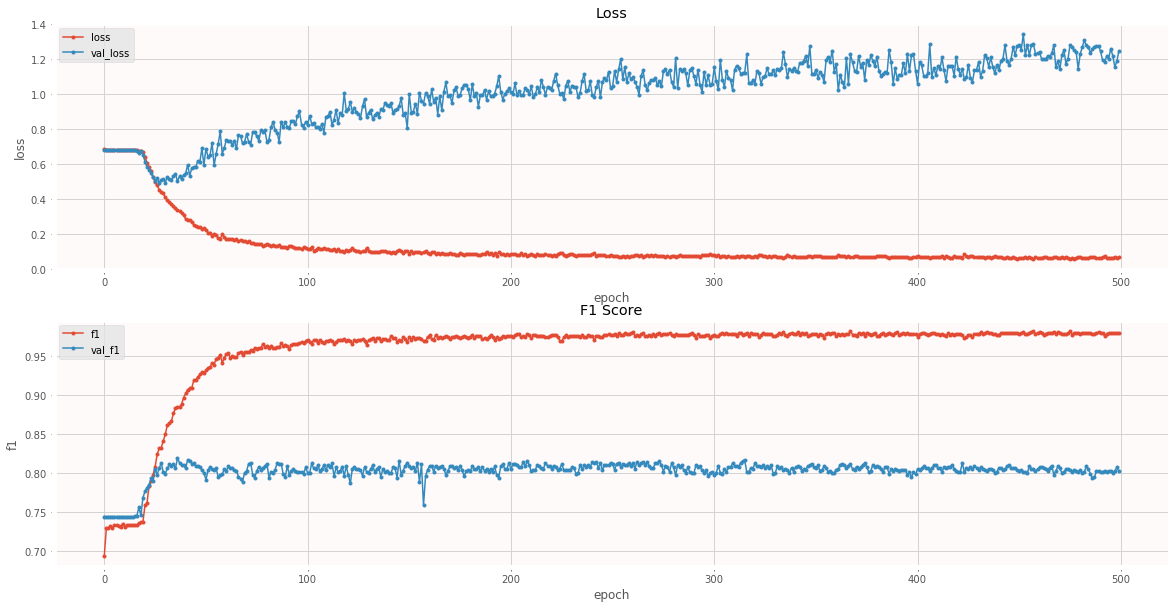

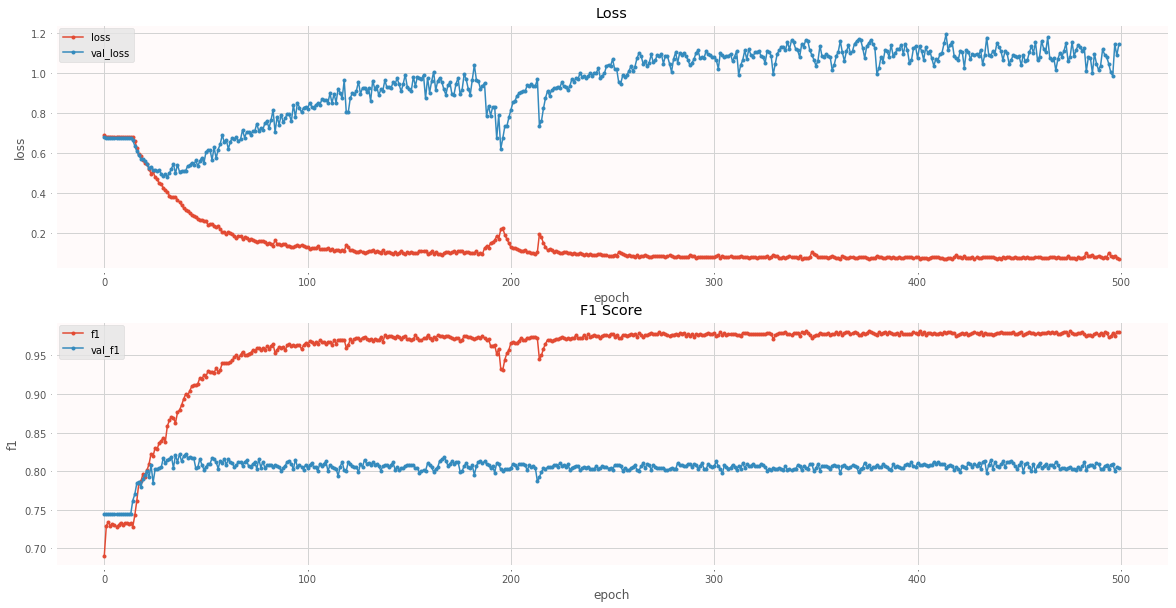

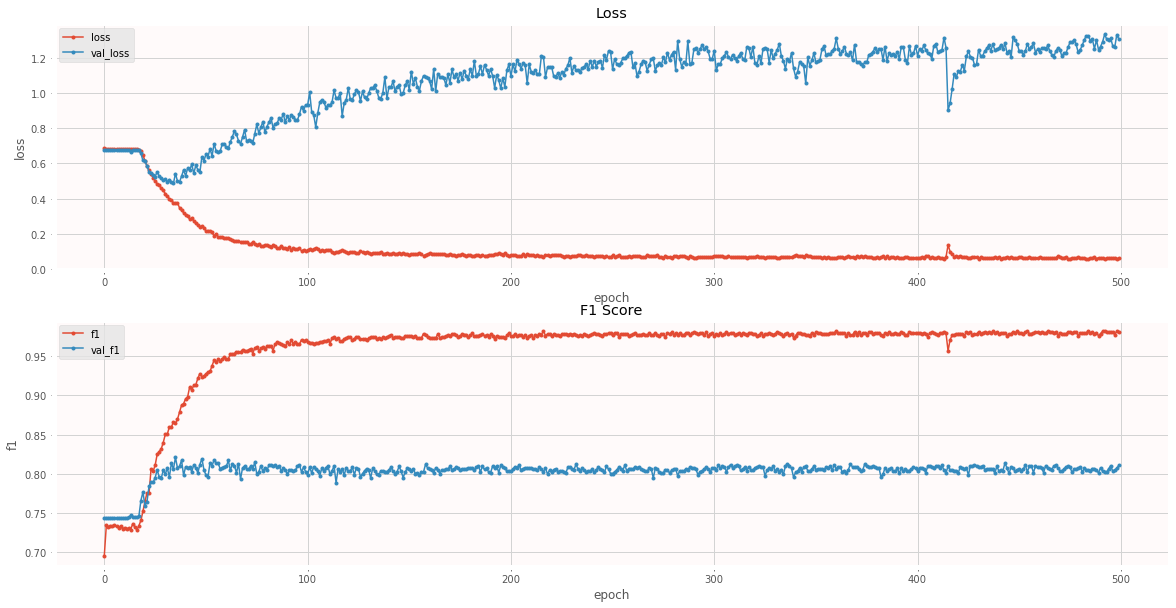

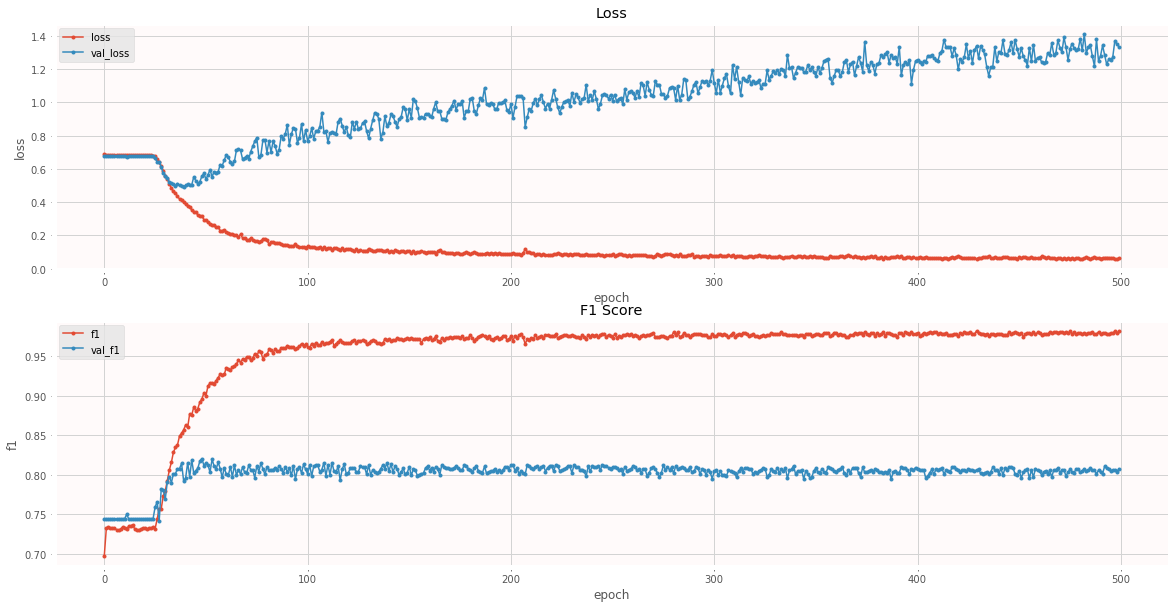

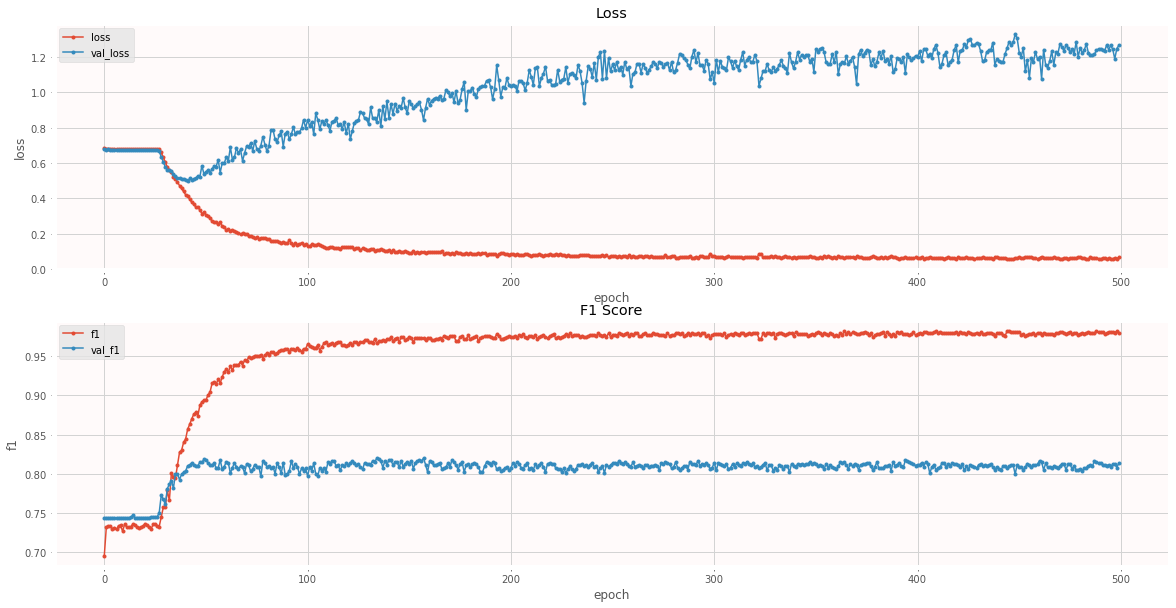

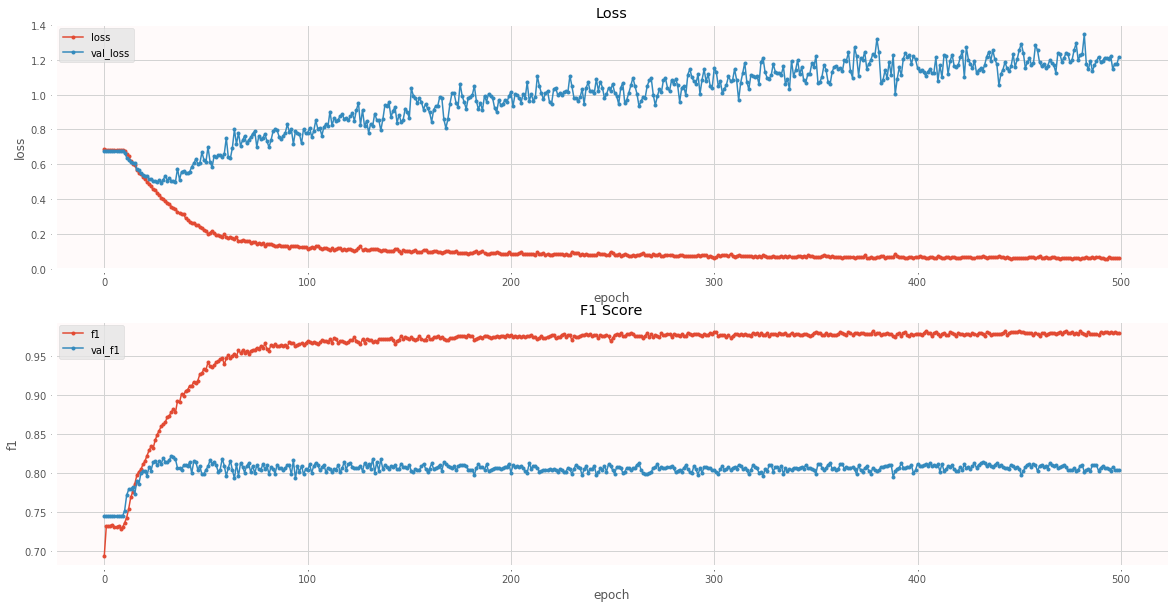

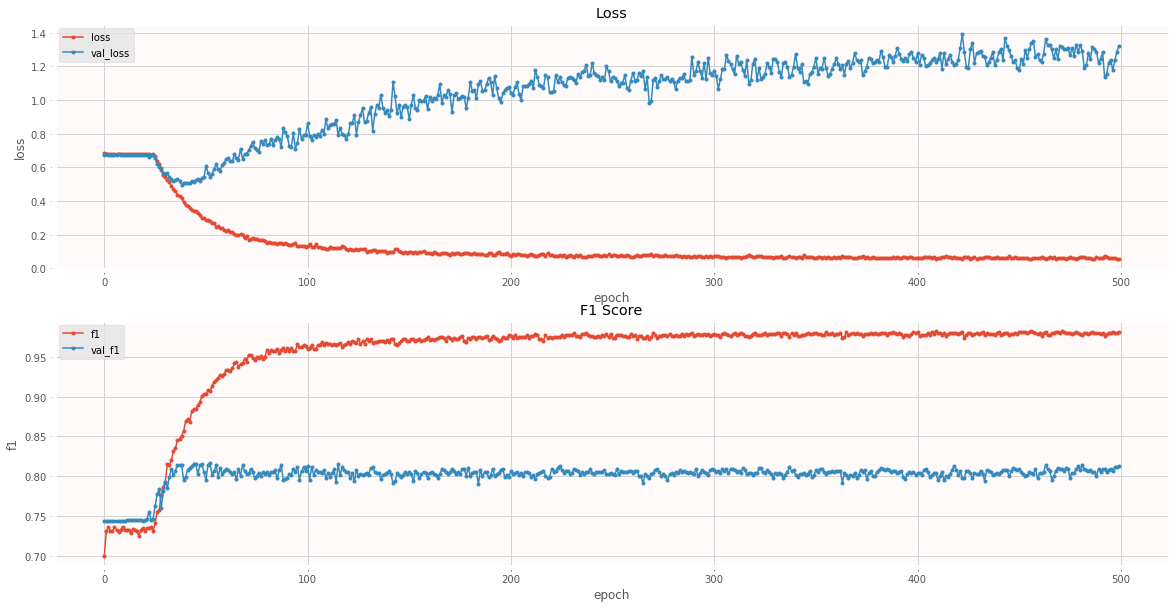

In [26]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [27]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_lstm(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 757  286]
 [ 327 1214]]
Training model using sgd.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 776  287]
 [ 308 1213]]
Training model using adagrad.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 833  316]
 [ 251 1184]]
Training model using adadelta.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 811  287]
 [ 273 1213]]
Training model using rmsprop.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 843  347]
 [ 241 1153]]
Training model using nadam.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 827  345]
 [ 257 1155]]
Training model using cocob.
==================== Start Training LSTM ====================
Confusion Matrix: 
 [[ 799  287]
 [ 285 1213]]
[[0.7628, 0.7984],
 [0.7697, 0.803],


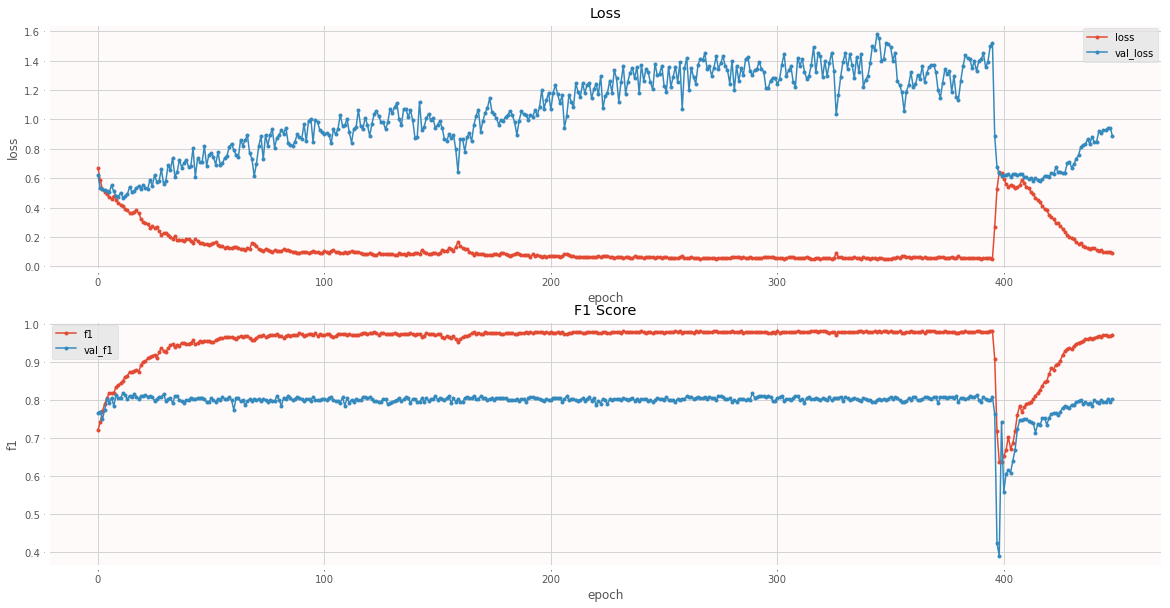

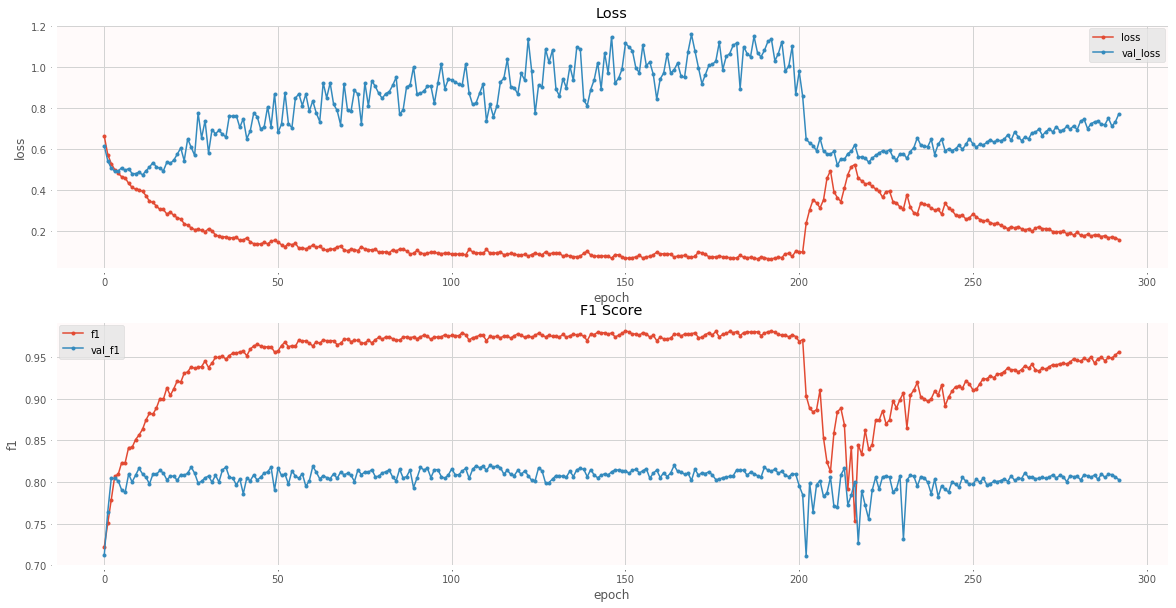

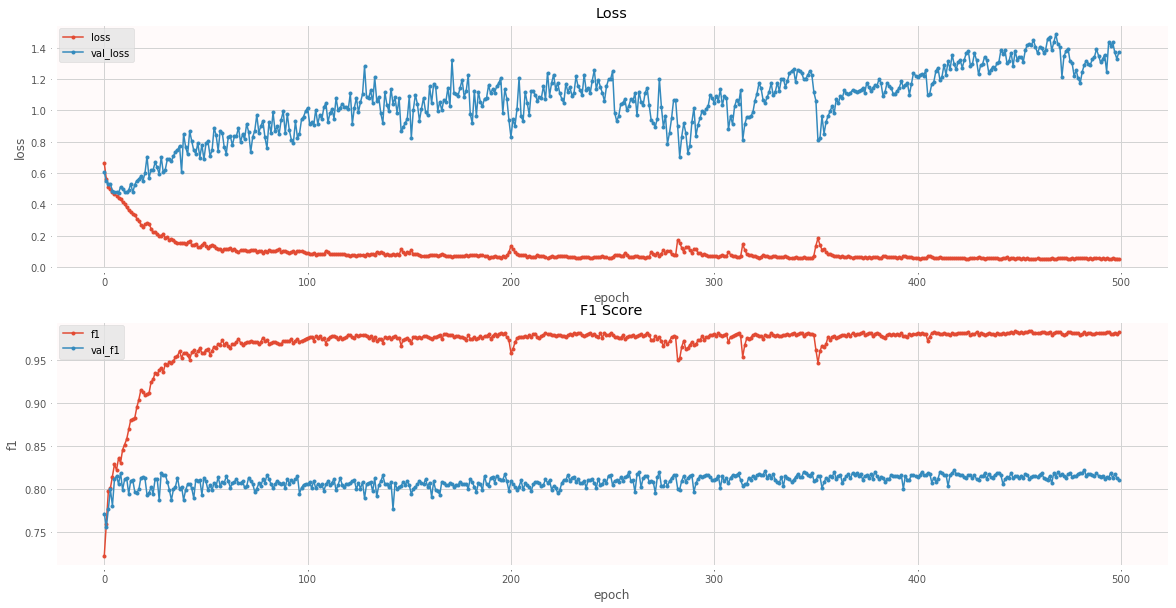

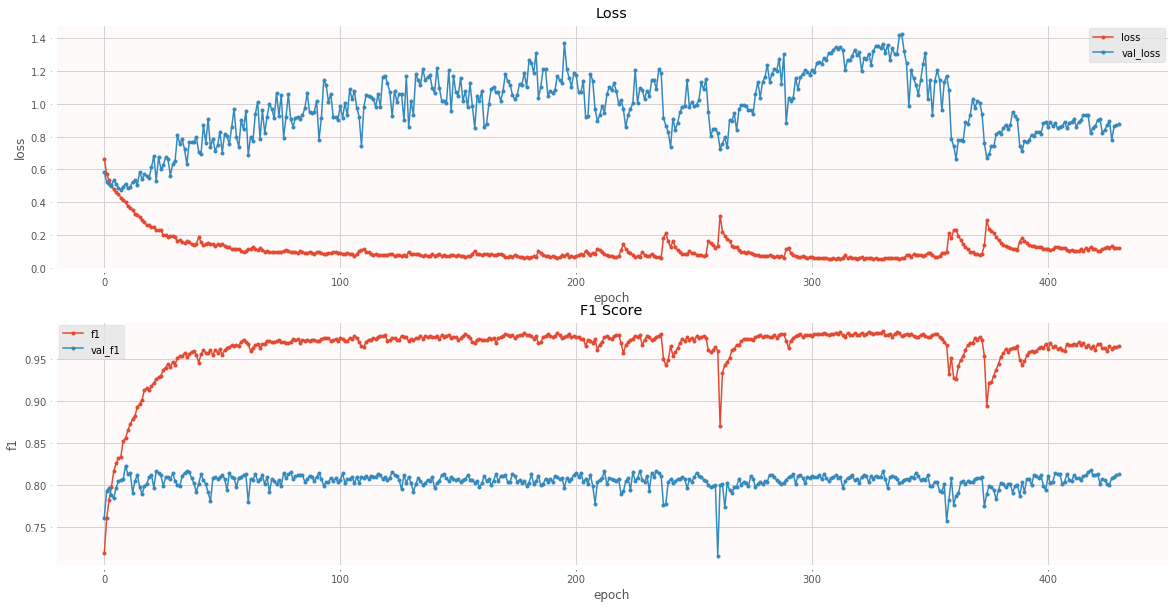

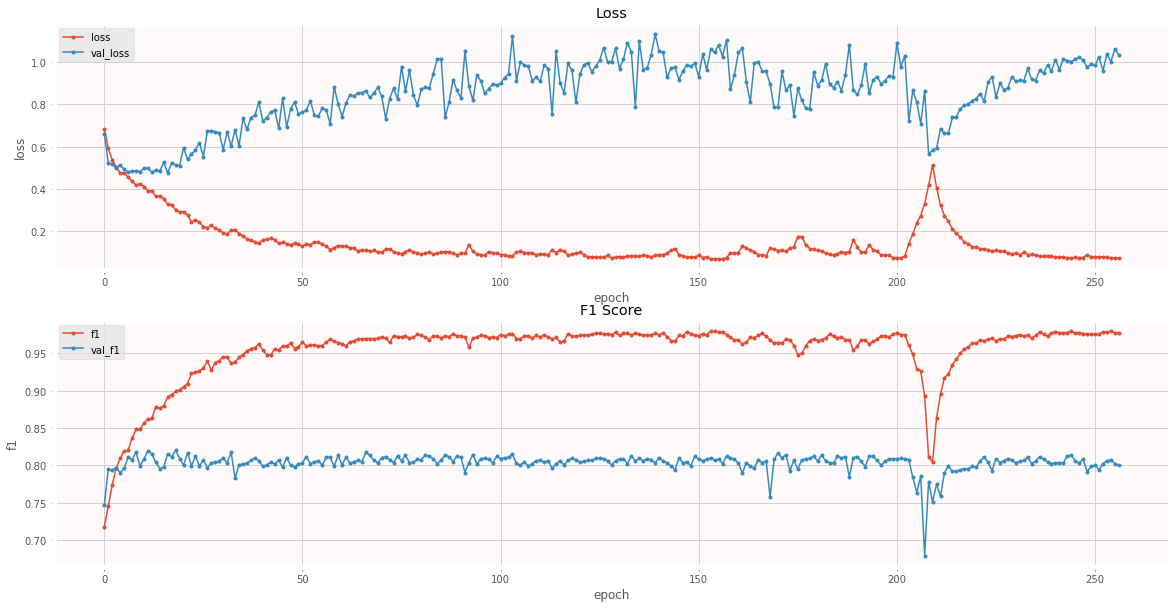

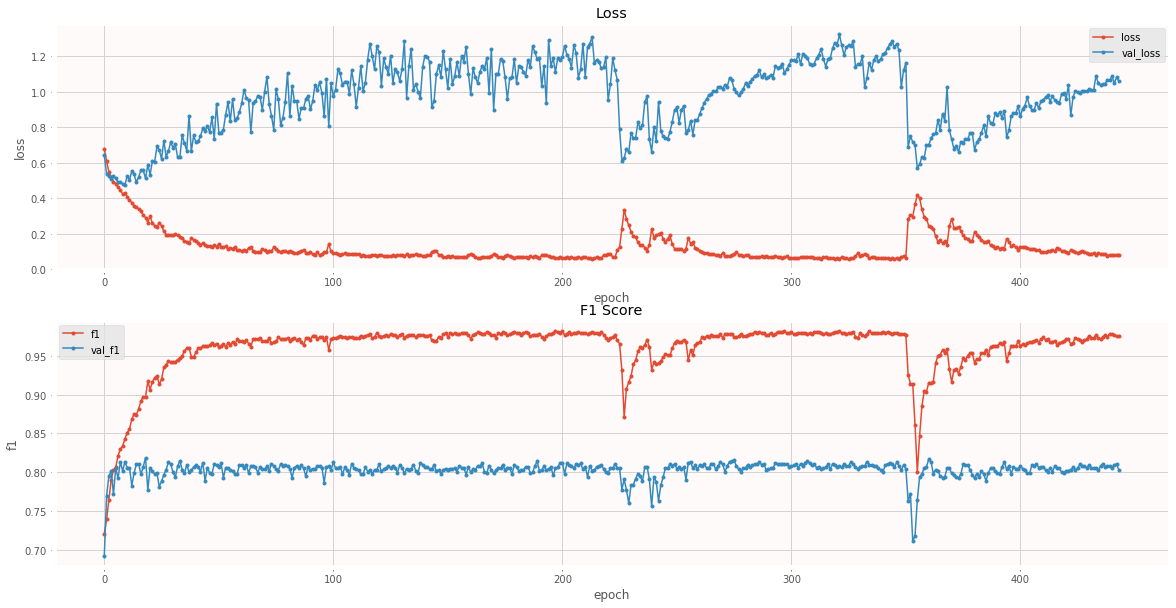

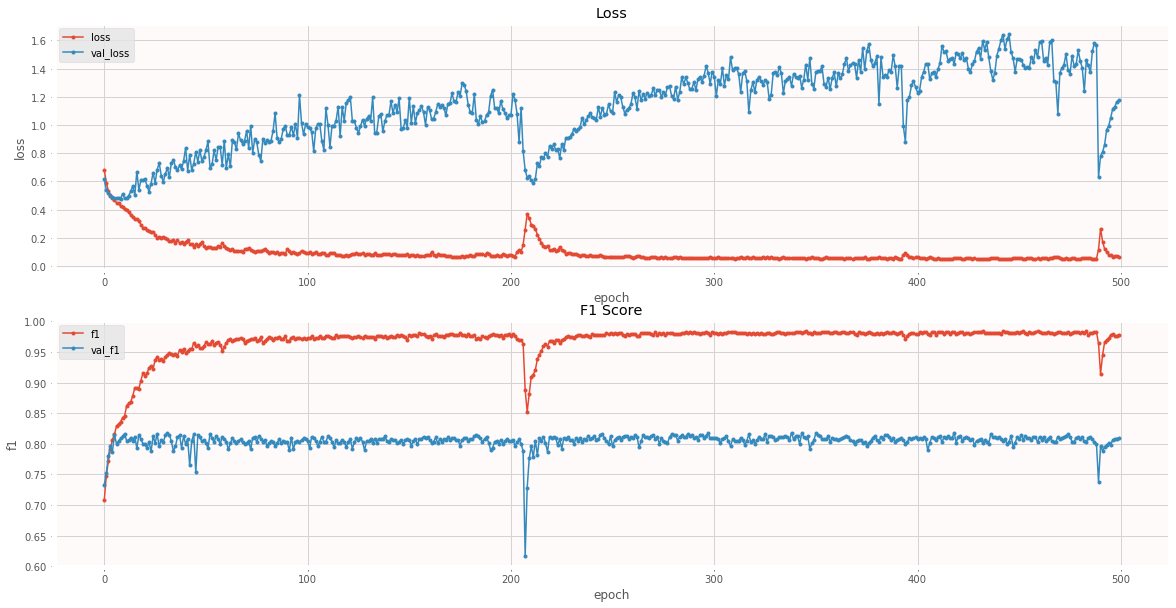

In [28]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [29]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_bilstm(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 820  286]
 [ 264 1214]]
Training model using sgd.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 797  297]
 [ 287 1203]]
Training model using adagrad.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 807  285]
 [ 277 1215]]
Training model using adadelta.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 812  289]
 [ 272 1211]]
Training model using rmsprop.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 802  270]
 [ 282 1230]]
Training model using nadam.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 809  279]
 [ 275 1221]]
Training model using cocob.
==================== Start Training BiLSTM ====================
Confusion Matrix: 
 [[ 799  286]
 [ 285 1214]]
[[0.7872, 0.8153],
 [0.

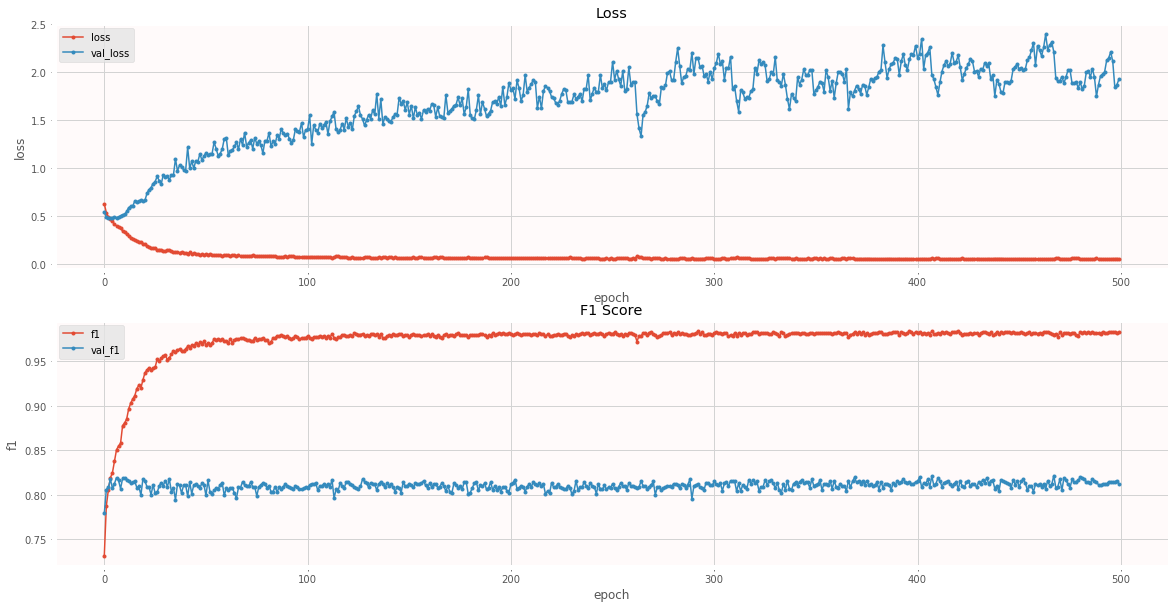

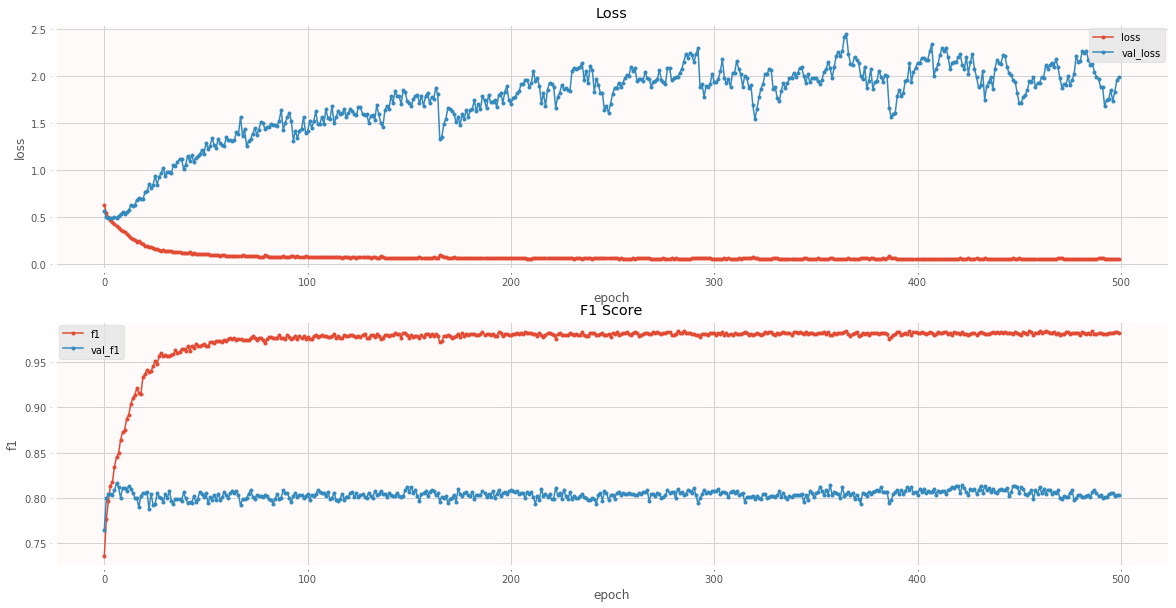

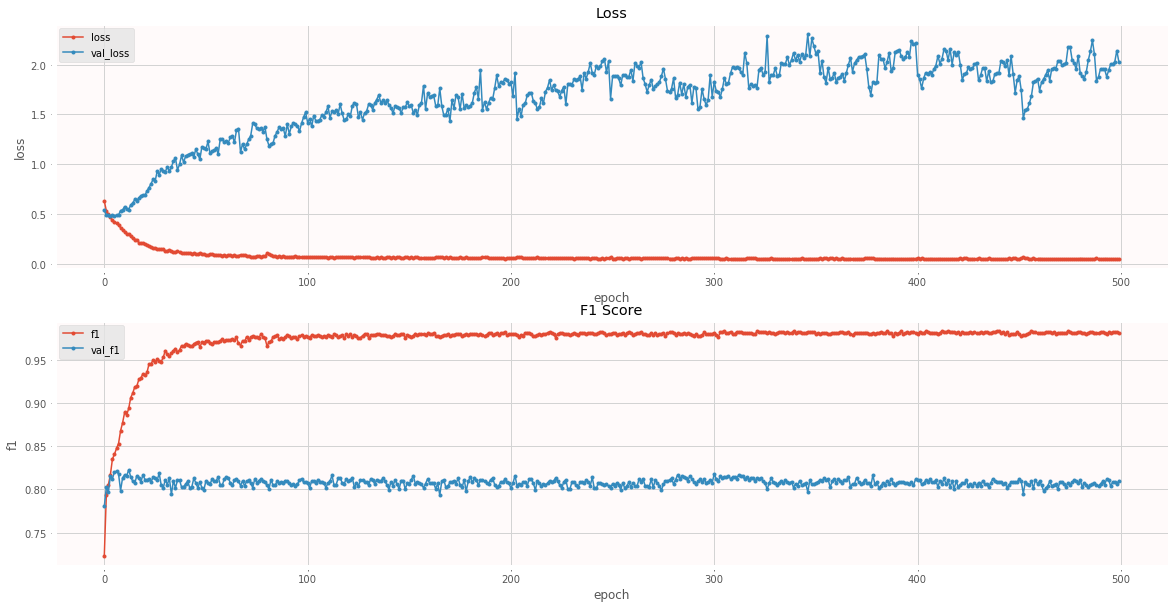

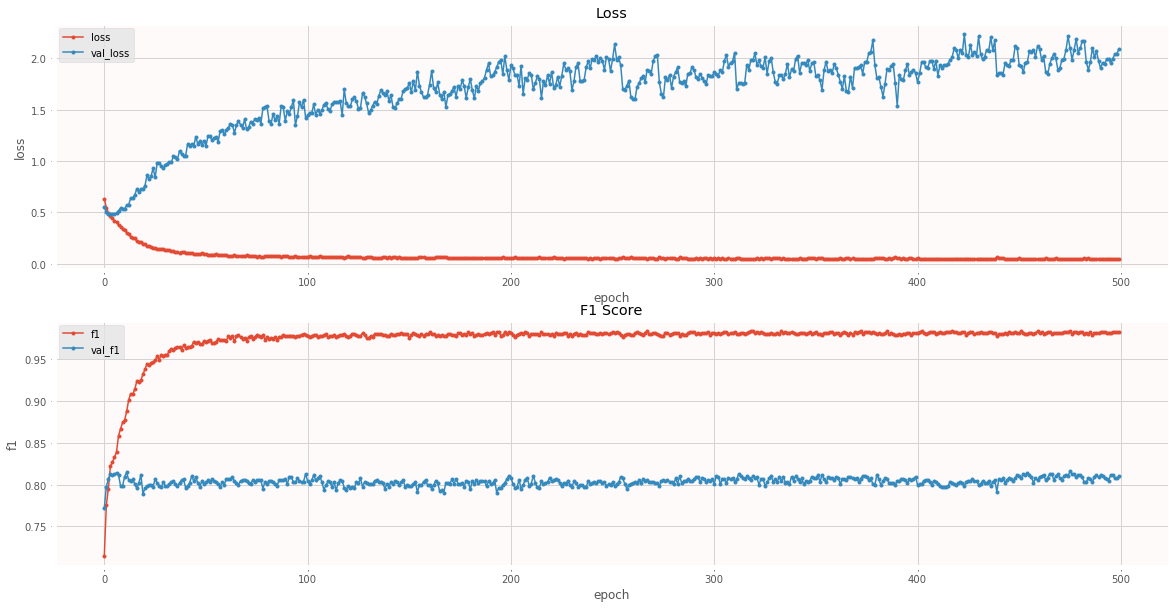

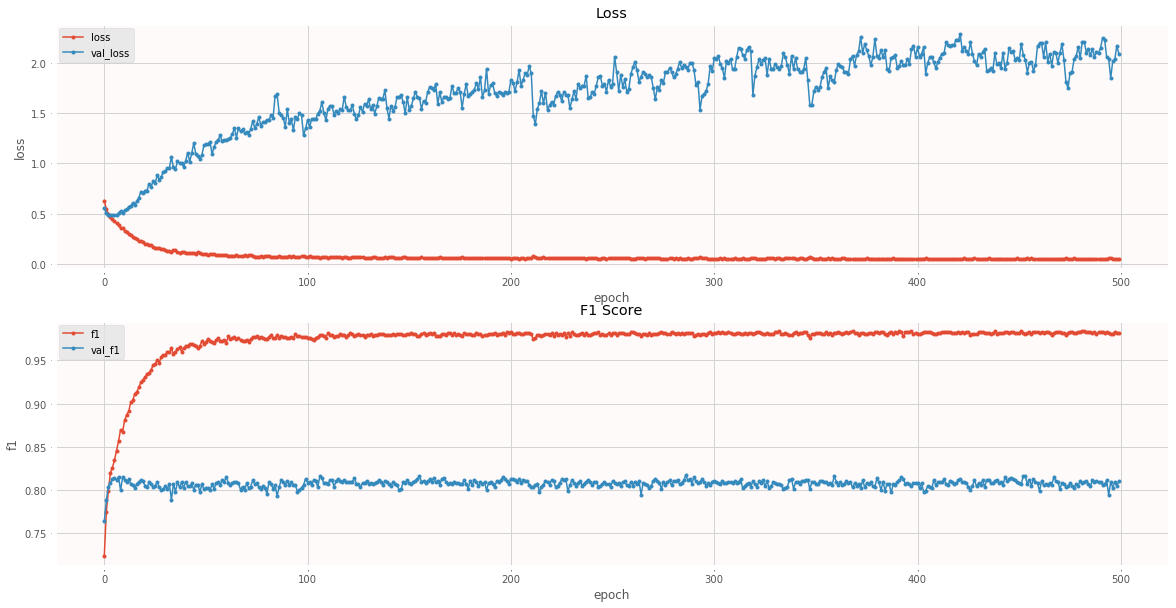

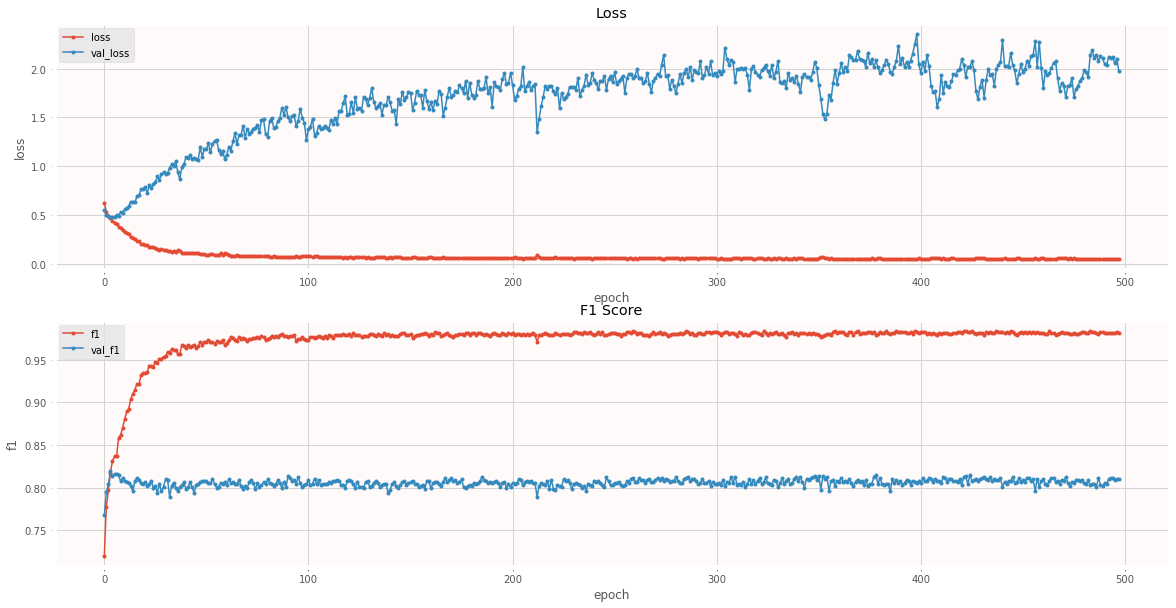

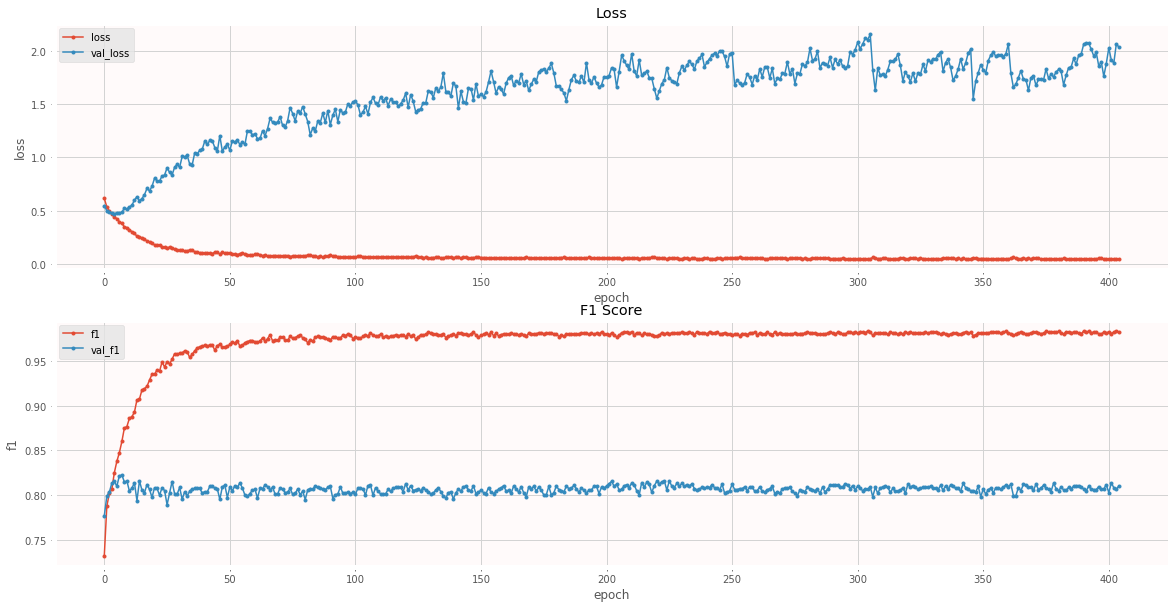

In [30]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [31]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_cnn_static(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.

==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 808  405]
 [ 276 1095]]
Training model using sgd.
==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 417  100]
 [ 667 1400]]
Training model using adagrad.
==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 464  129]
 [ 620 1371]]
Training model using adadelta.
==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 744  289]
 [ 340 1211]]
Training model using rmsprop.
==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 728  313]
 [ 356 1187]]
Training model using nadam.
==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[ 427  105]
 [ 657 1395]]
Training model using cocob.
==================== Start Training CNN-static ====================
Confusion Matrix: 
 [[854 518]
 [230 982]

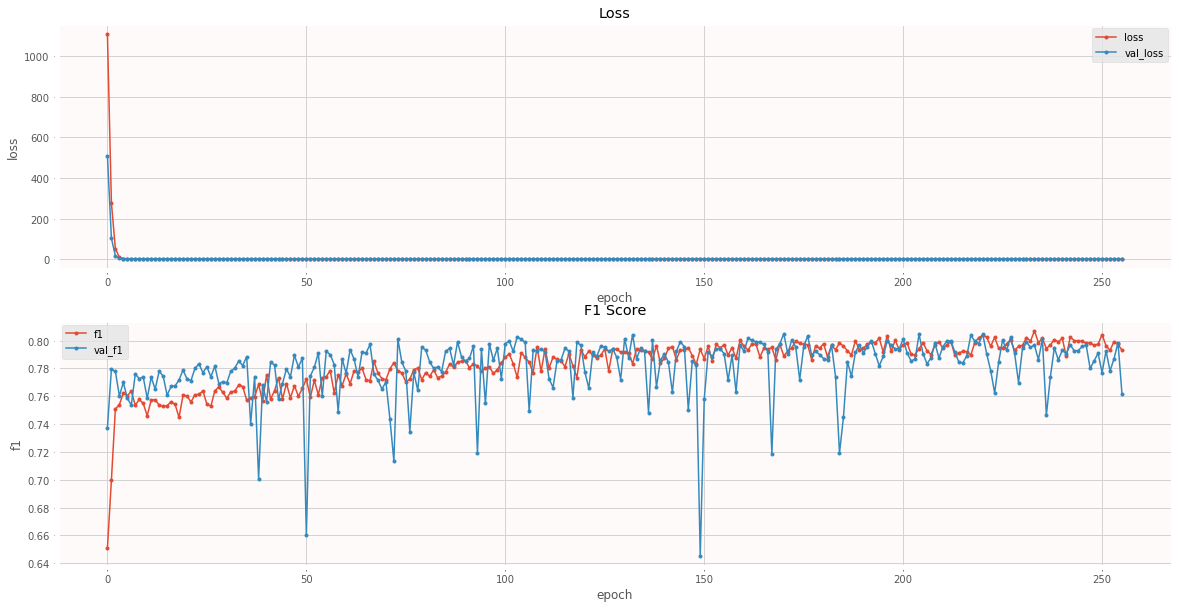

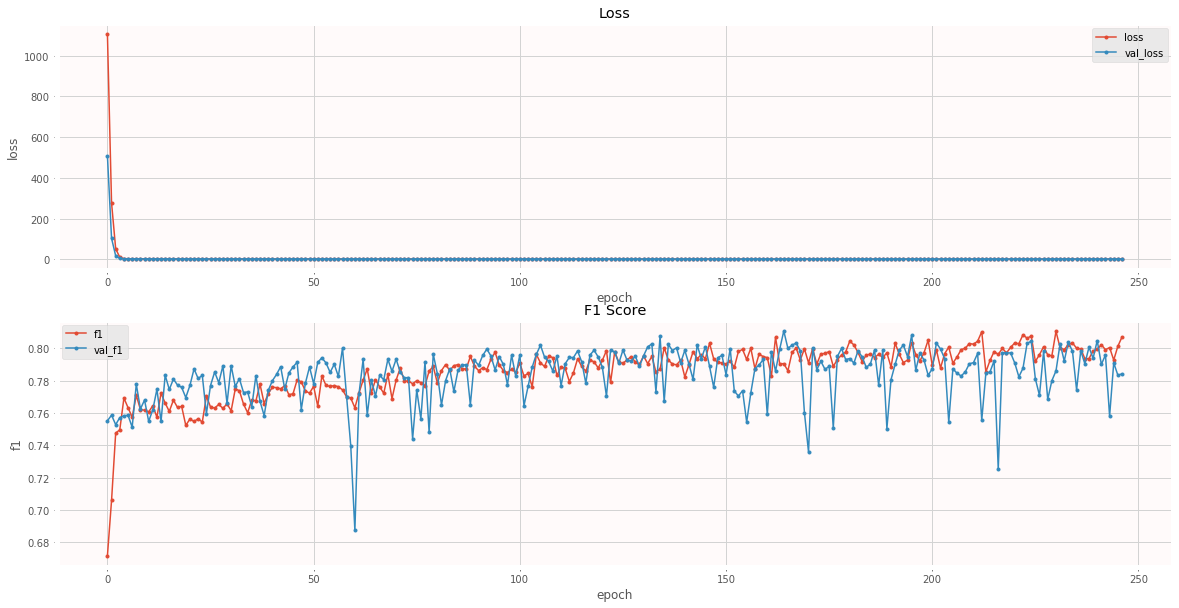

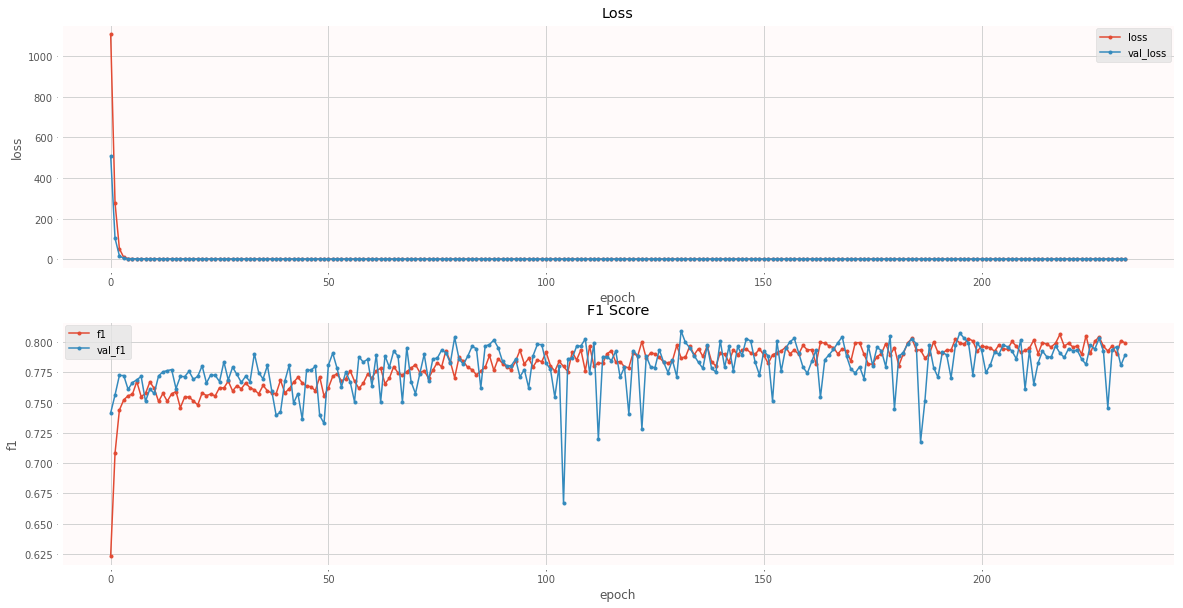

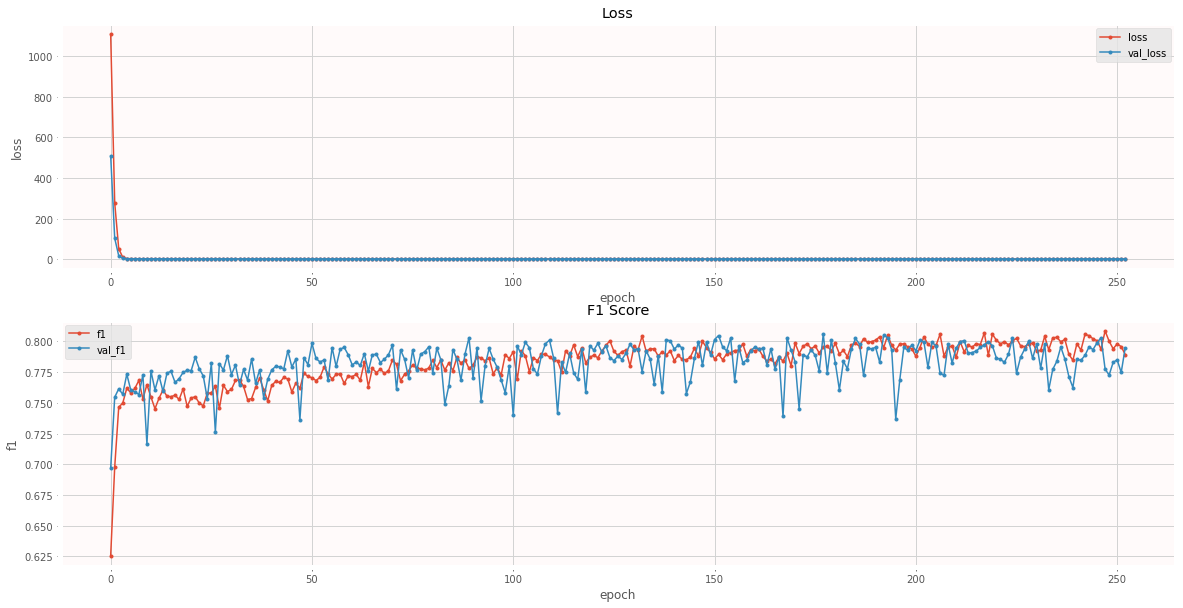

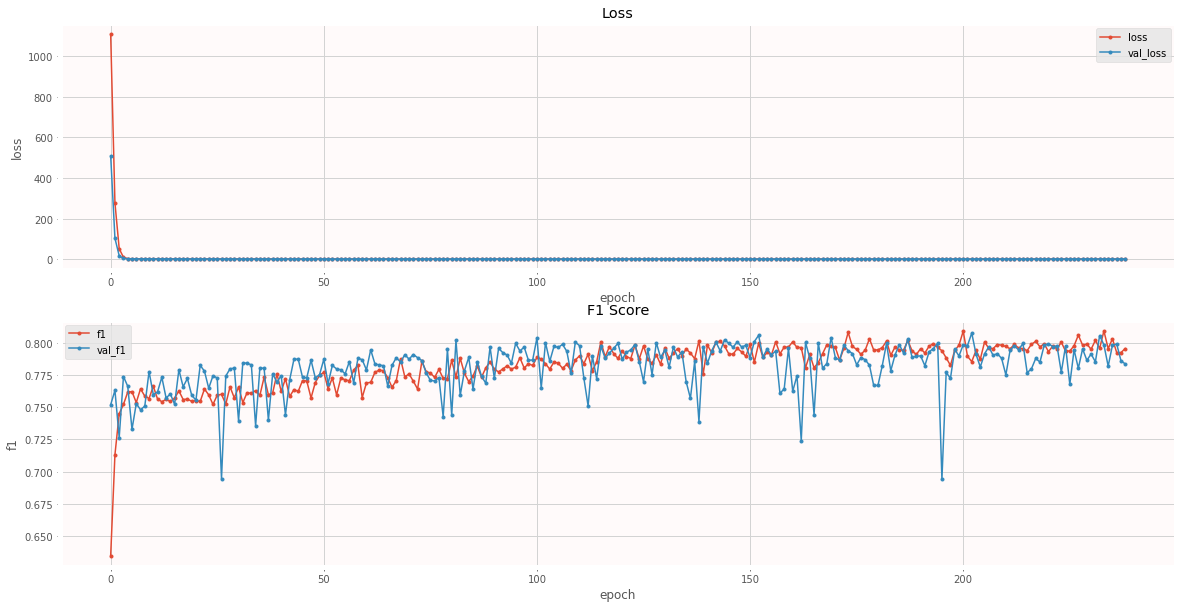

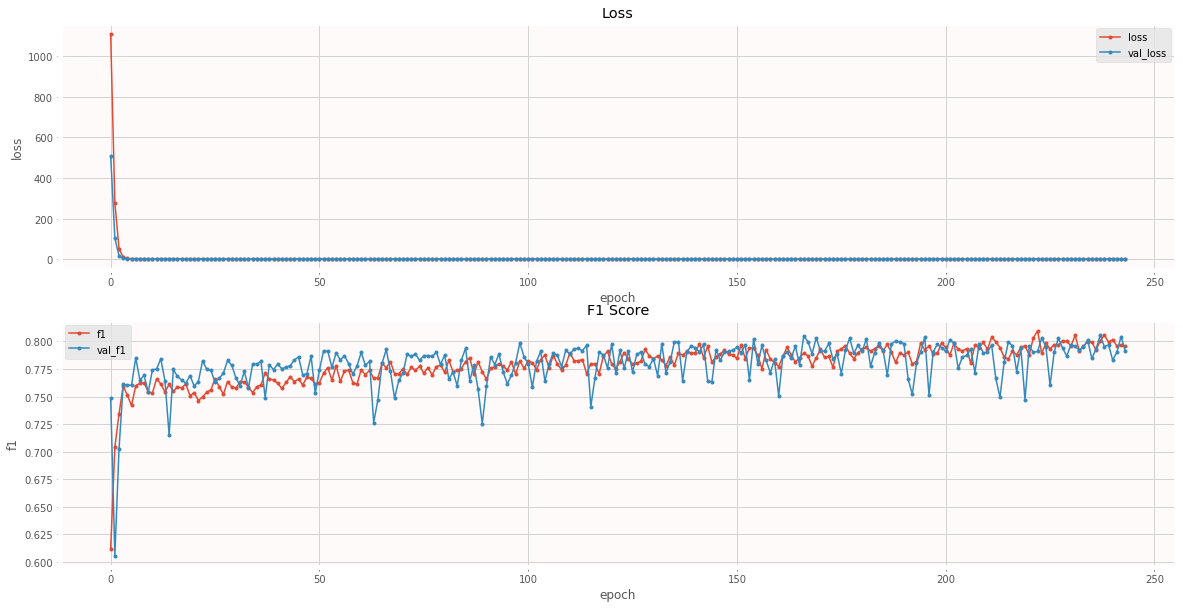

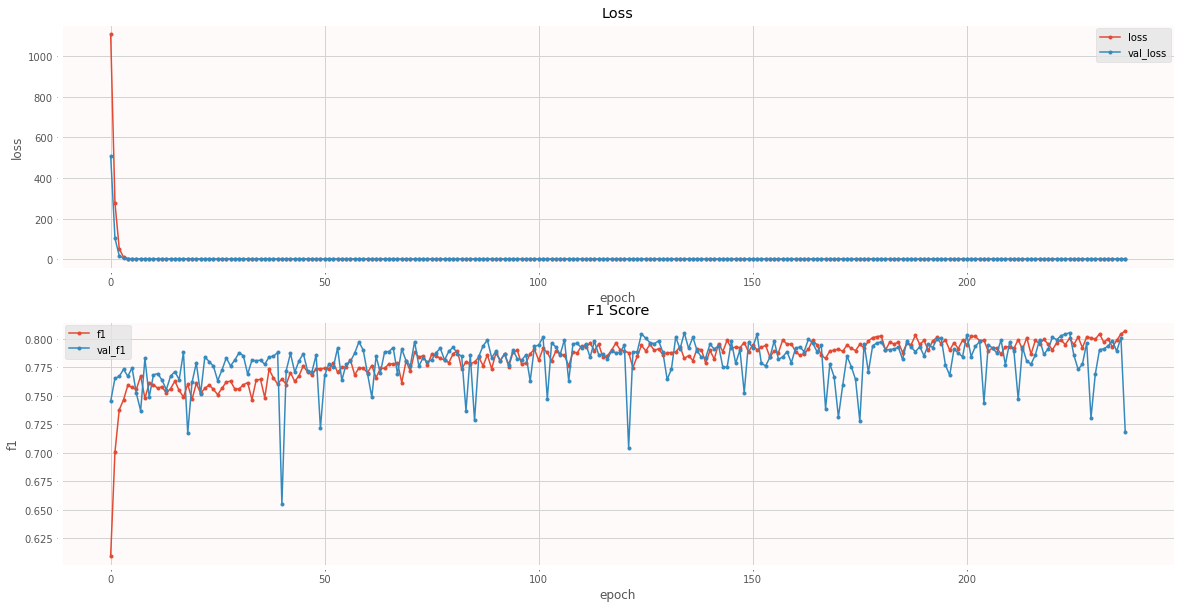

In [32]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [33]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_cnn_multichannel(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_prob = model.predict([x_test, x_test, x_test])
    y_prob = y_prob.squeeze()
    y_pred = (y_prob > 0.5)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.
==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 811  360]
 [ 273 1140]]
Training model using sgd.
==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 795  363]
 [ 289 1137]]
Training model using adagrad.
==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 880  497]
 [ 204 1003]]
Training model using adadelta.
==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 752  273]
 [ 332 1227]]
Training model using rmsprop.
==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 800  378]
 [ 284 1122]]
Training model using nadam.
==================== Start Training CNN-multichannel ====================
Confusion Matrix: 
 [[ 779  370]
 [ 305 1130]]
Training model using cocob.
==================== Start Training CNN-multichannel ====================


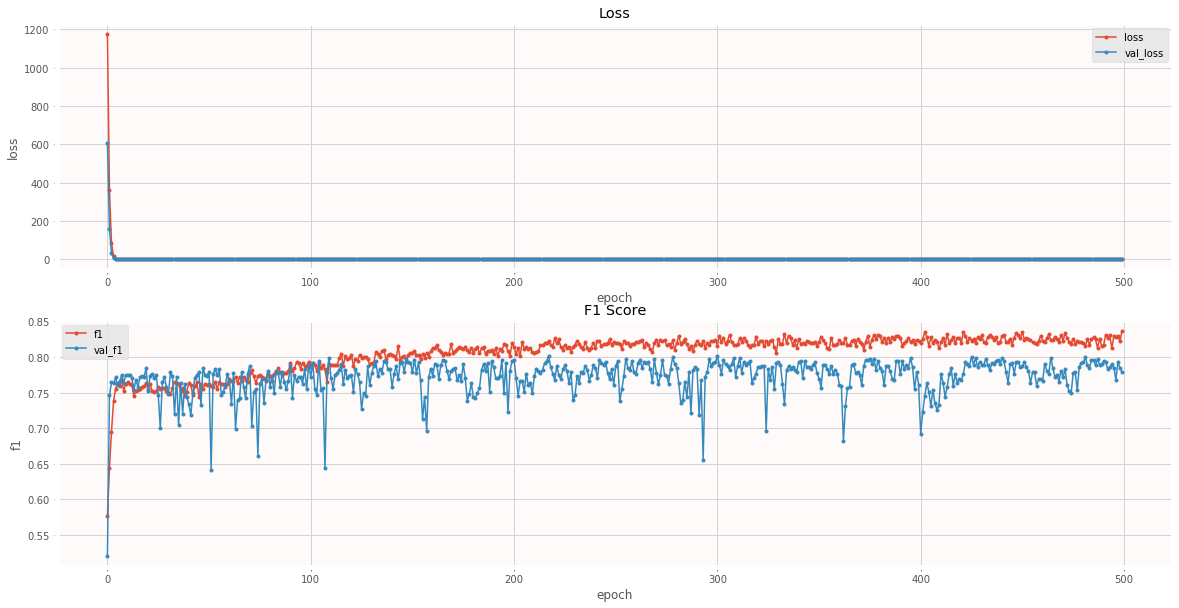

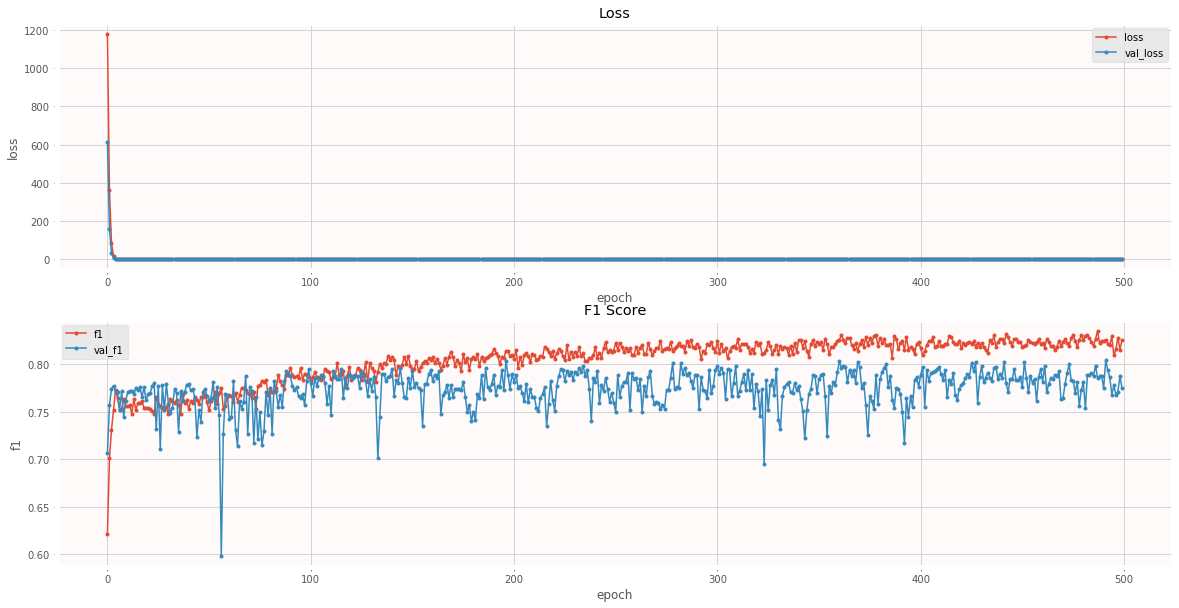

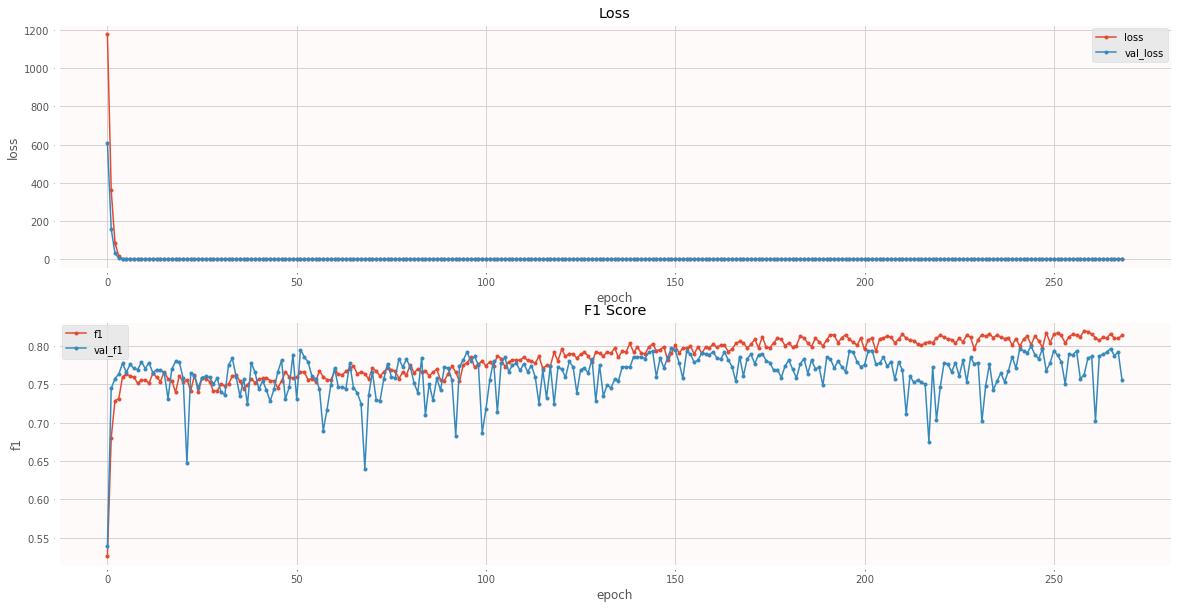

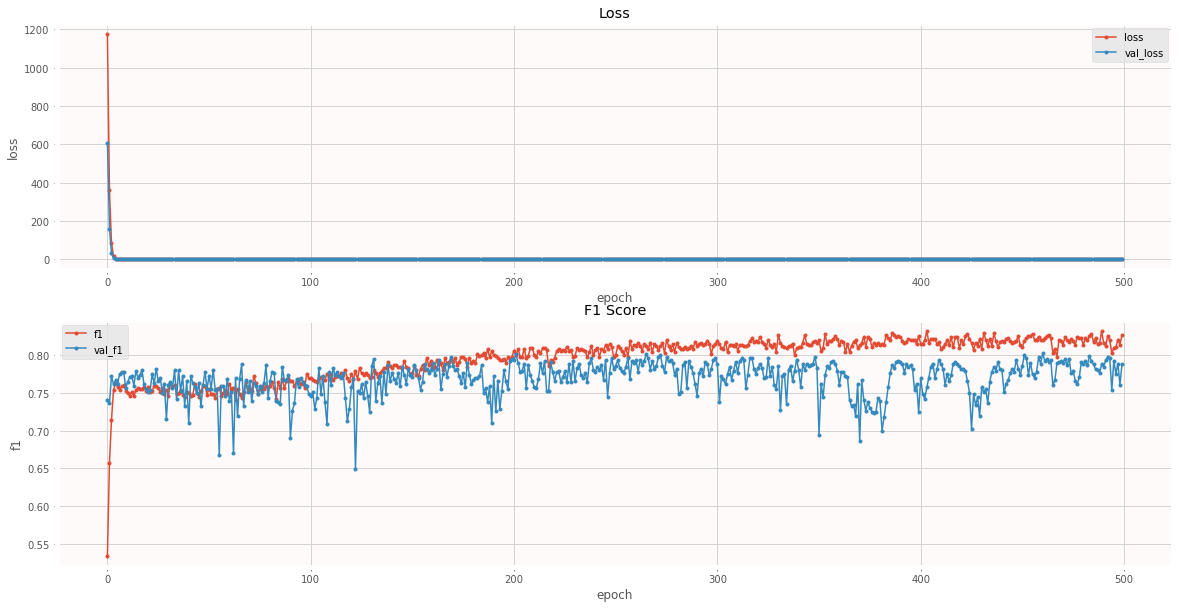

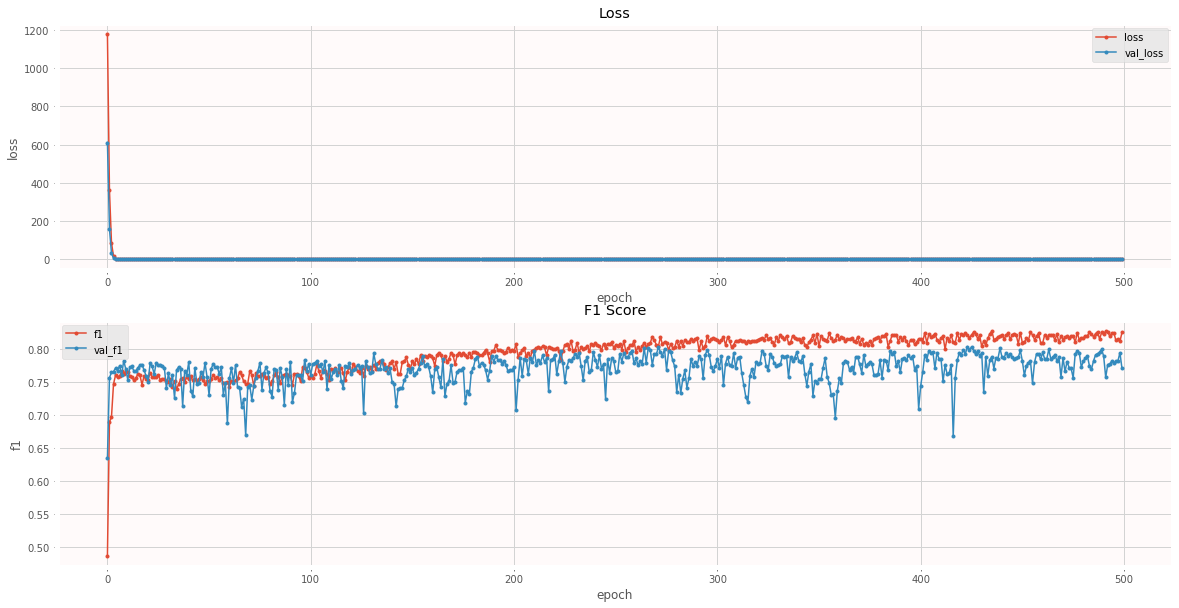

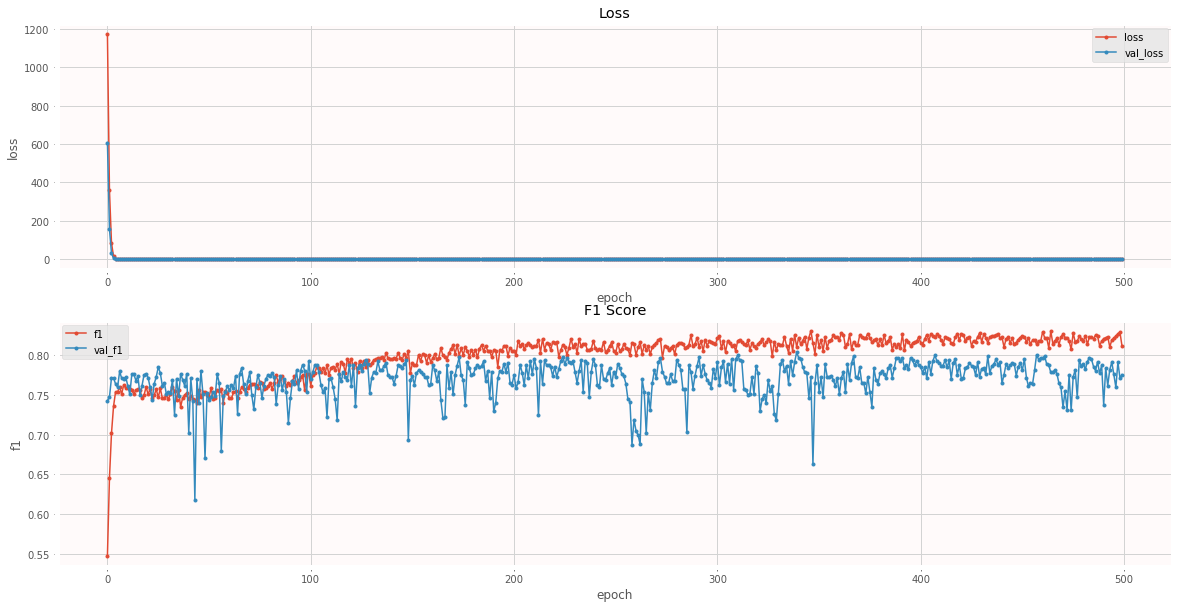

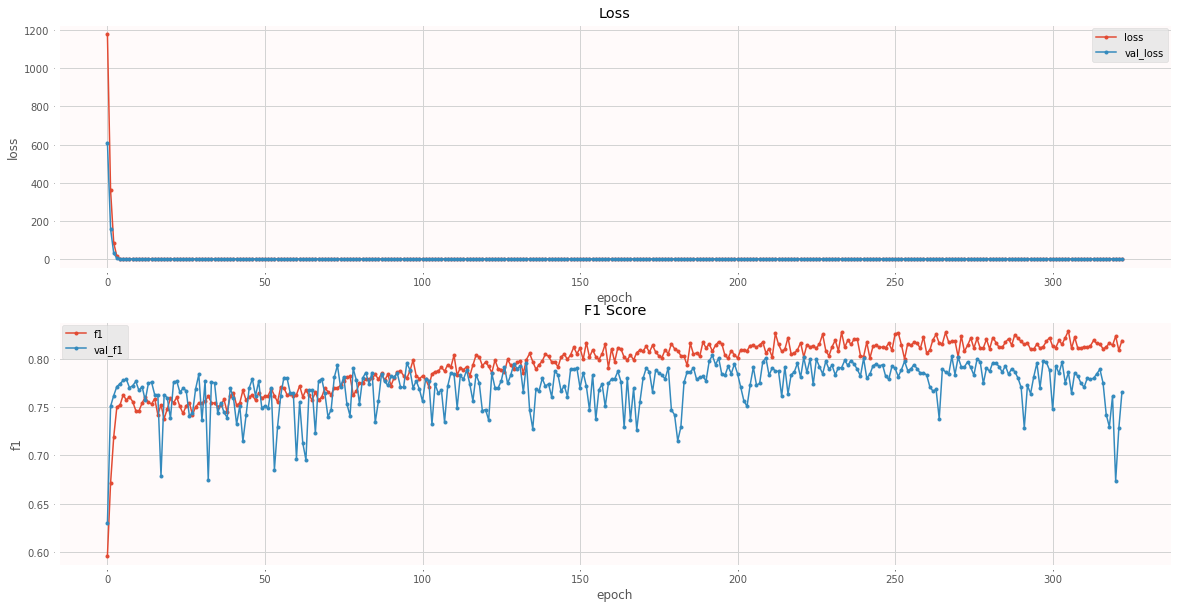

In [34]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [35]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_cnn_lstm(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 765  252]
 [ 319 1248]]
Training model using sgd.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 850  316]
 [ 234 1184]]
Training model using adagrad.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 795  286]
 [ 289 1214]]
Training model using adadelta.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 790  287]
 [ 294 1213]]
Training model using rmsprop.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 807  328]
 [ 277 1172]]
Training model using nadam.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 799  291]
 [ 285 1209]]
Training model using cocob.
==================== Start Training CNN-LSTM ====================
Confusion Matrix: 
 [[ 819  328]
 [ 265 1172]]
[[0.779, 

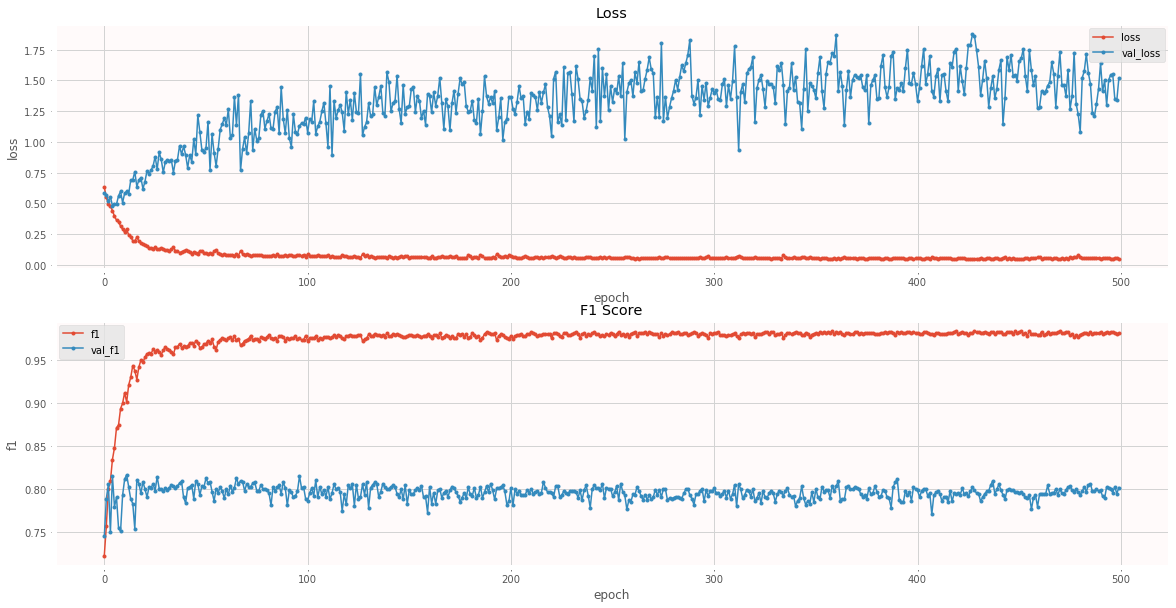

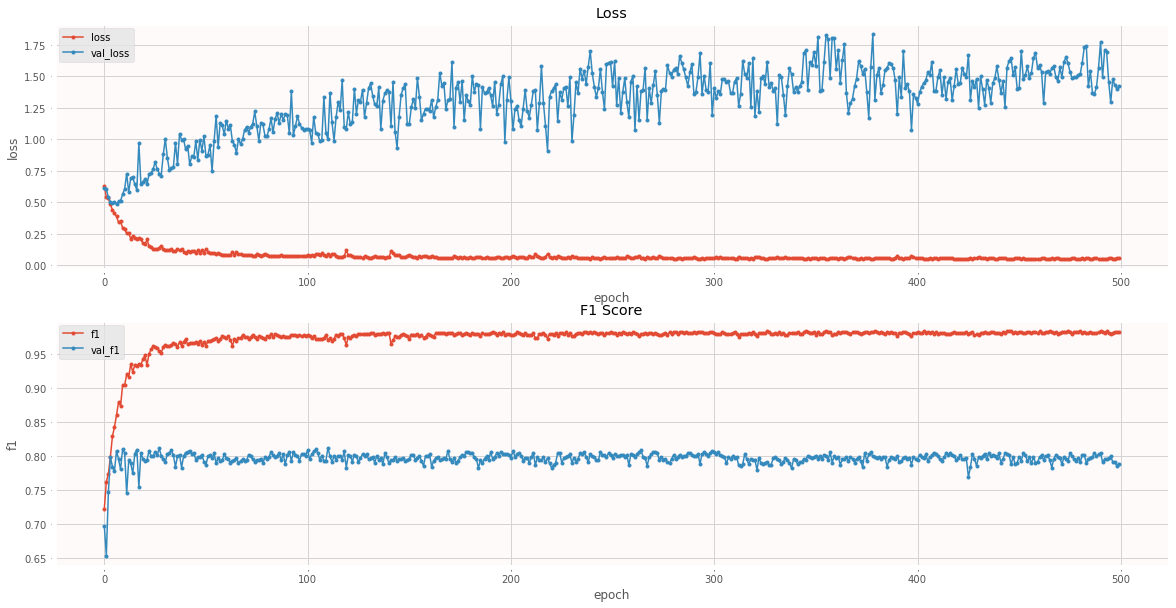

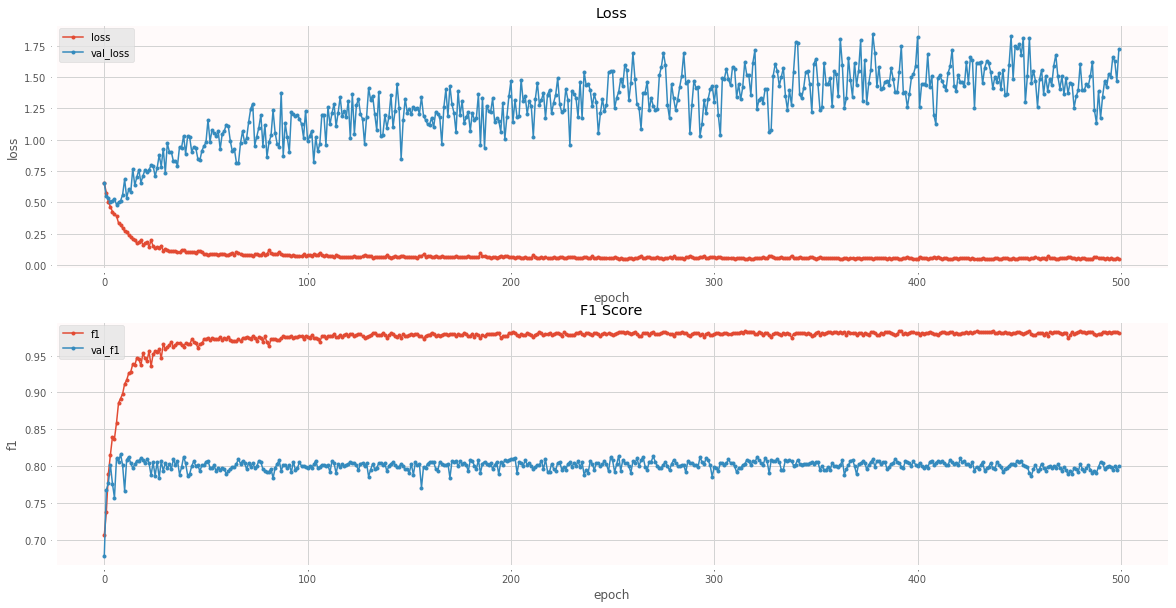

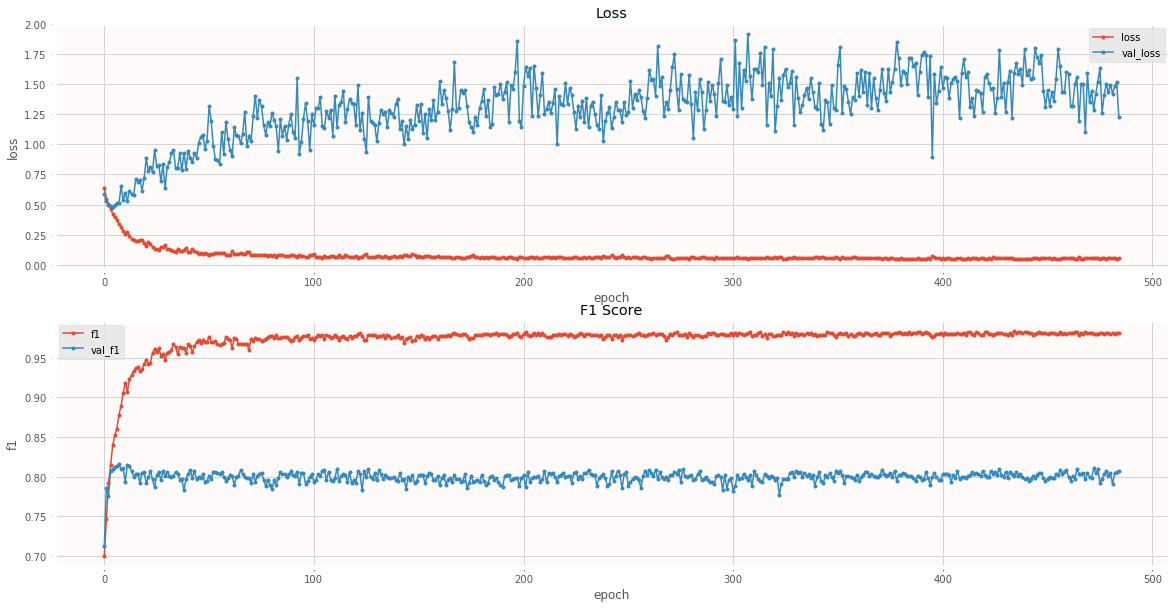

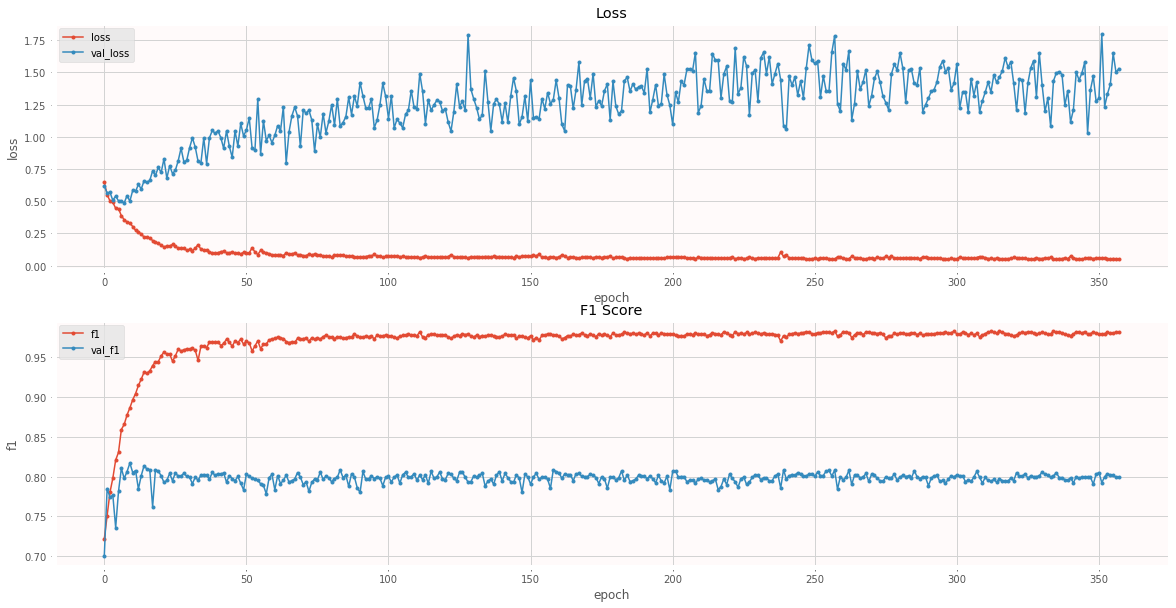

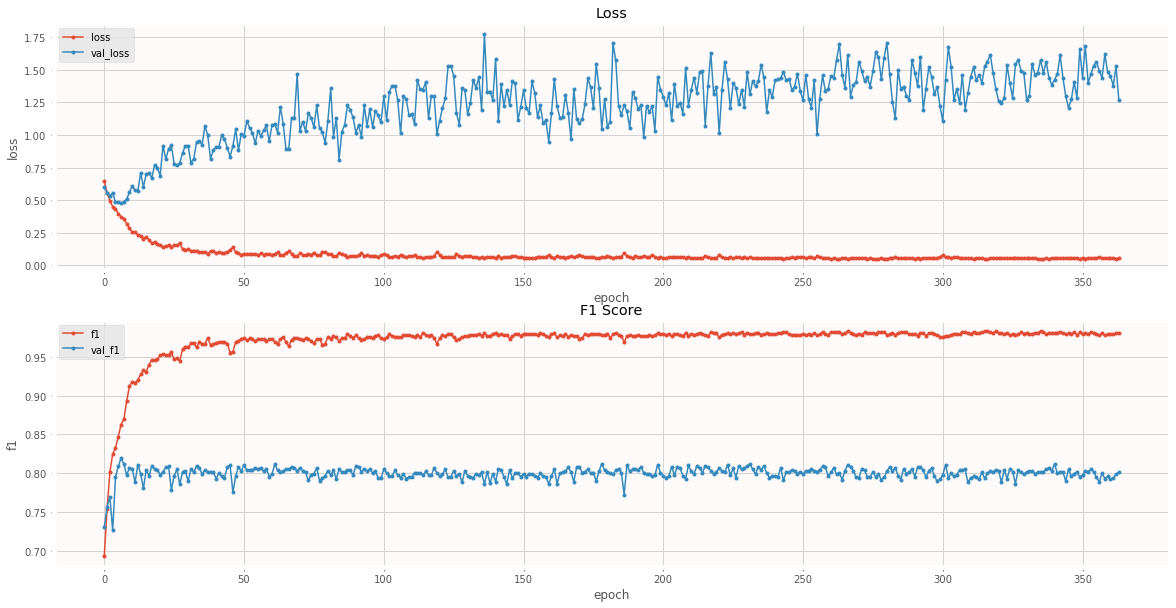

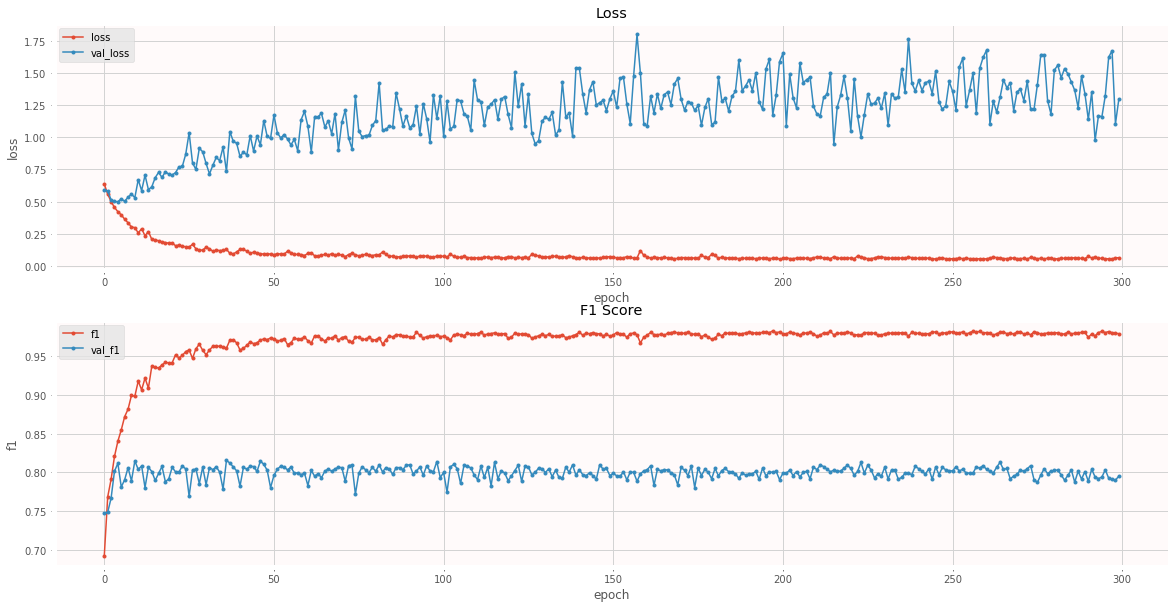

In [36]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [37]:
opt_list = ["adam", "sgd", "adagrad", "adadelta", "rmsprop", "nadam", "cocob"]
history_list = []
model_list = []
performance = []

for i, optimizer in enumerate([adam, sgd, adagrad, adadelta, rmsprop, nadam, cocob]):
    print("Training model using {}.".format(opt_list[i]))
    history, model = train_text_resnet(x_train, y_train, embedding_matrix)
    history_list.append(history)
    model_list.append(model)
    
    y_pred = predict(x_test, model)
    acc_score = accuracy_score(y_pred, y_test)
    f1 = f1_score(y_pred, y_test)
    performance.append([round(acc_score, 4), round(f1, 4)])
    print("Confusion Matrix: \n", confusion_matrix(y_pred, y_test))
pprint(performance)

Training model using adam.

Confusion Matrix: 
 [[ 760  366]
 [ 324 1134]]
Training model using sgd.
Confusion Matrix: 
 [[ 707  345]
 [ 377 1155]]
Training model using adagrad.
Confusion Matrix: 
 [[ 759  334]
 [ 325 1166]]
Training model using adadelta.
Confusion Matrix: 
 [[ 758  362]
 [ 326 1138]]
Training model using rmsprop.
Confusion Matrix: 
 [[ 692  301]
 [ 392 1199]]
Training model using nadam.
Confusion Matrix: 
 [[ 716  340]
 [ 368 1160]]
Training model using cocob.
Confusion Matrix: 
 [[ 690  279]
 [ 394 1221]]
[[0.733, 0.7667],
 [0.7206, 0.7619],
 [0.745, 0.7797],
 [0.7337, 0.7679],
 [0.7318, 0.7758],
 [0.726, 0.7662],
 [0.7396, 0.7839]]


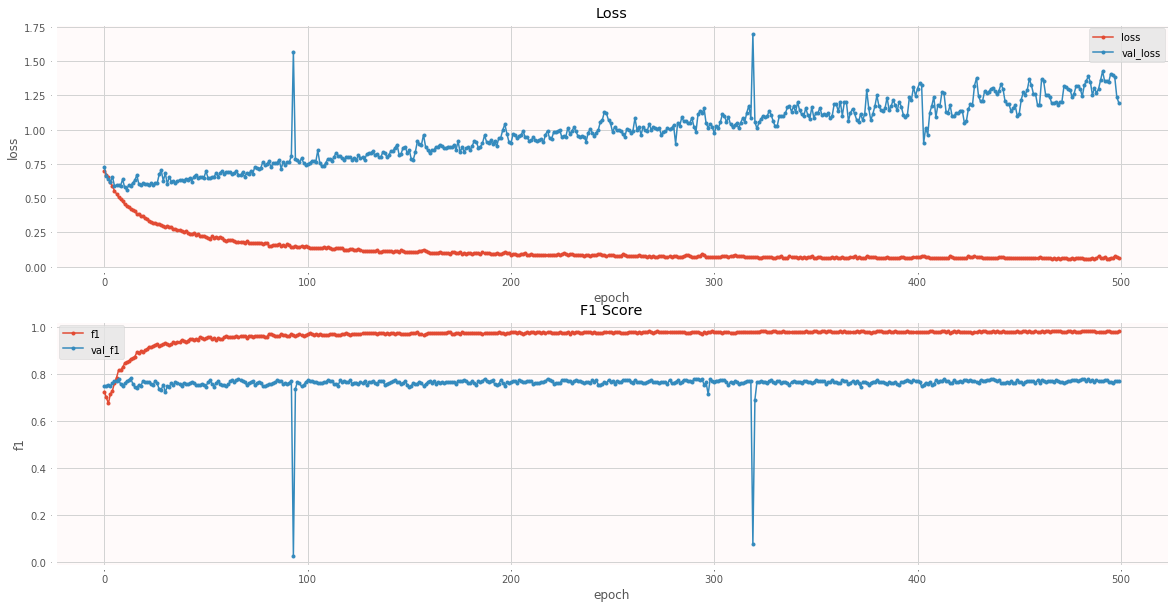

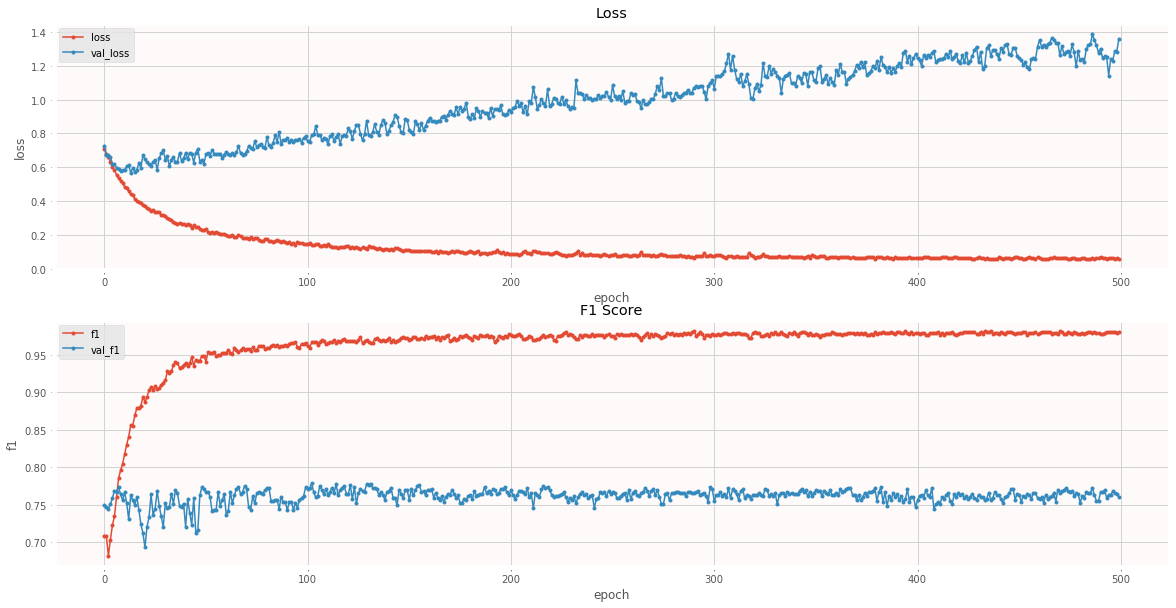

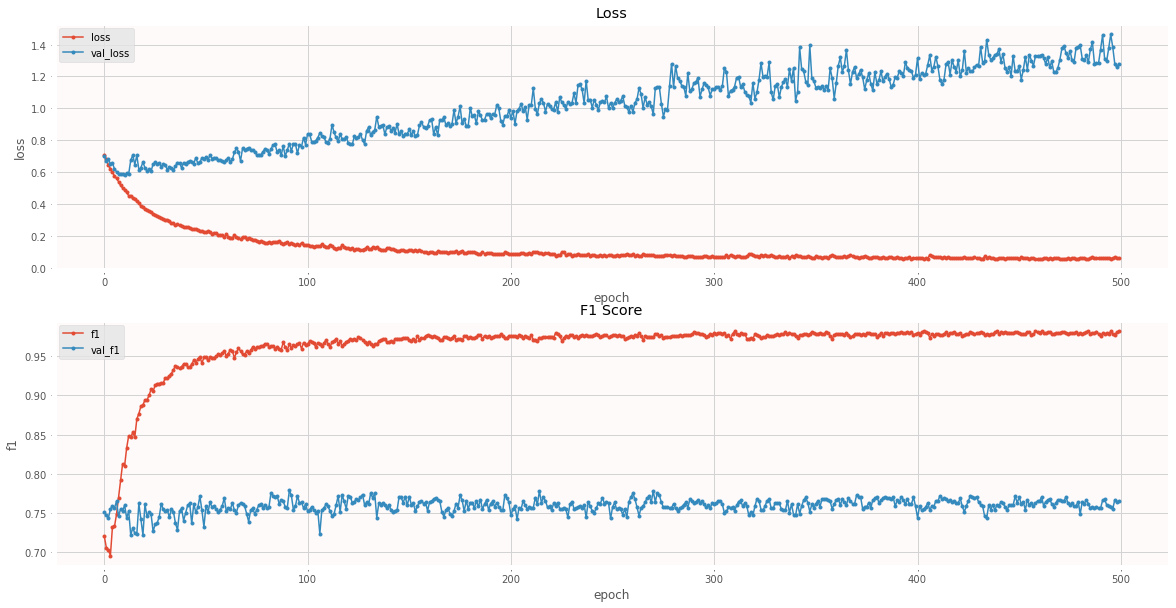

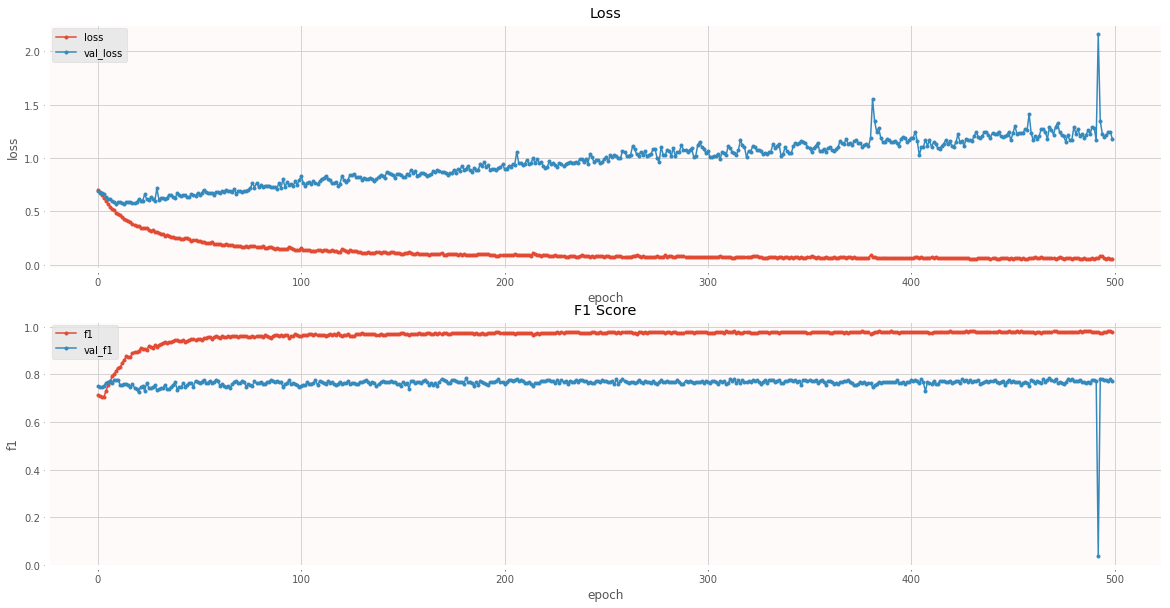

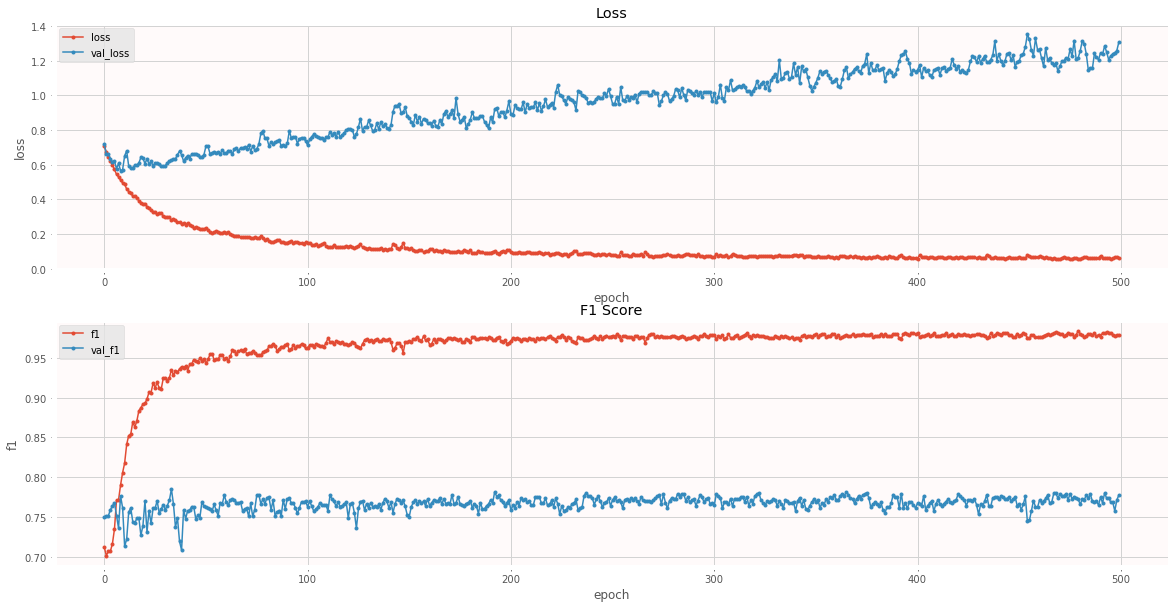

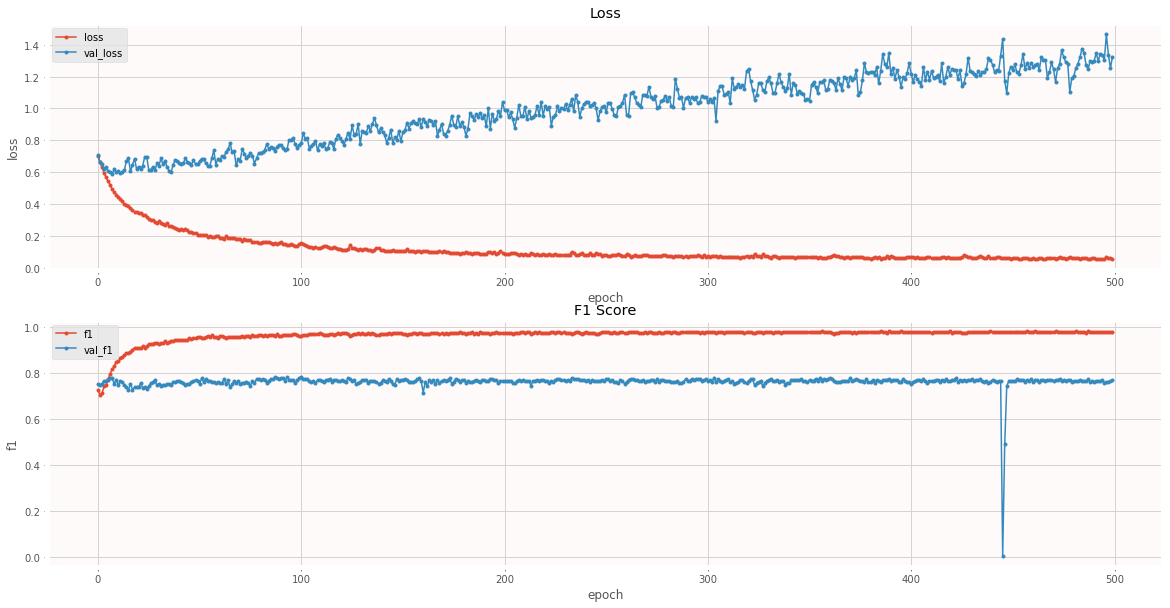

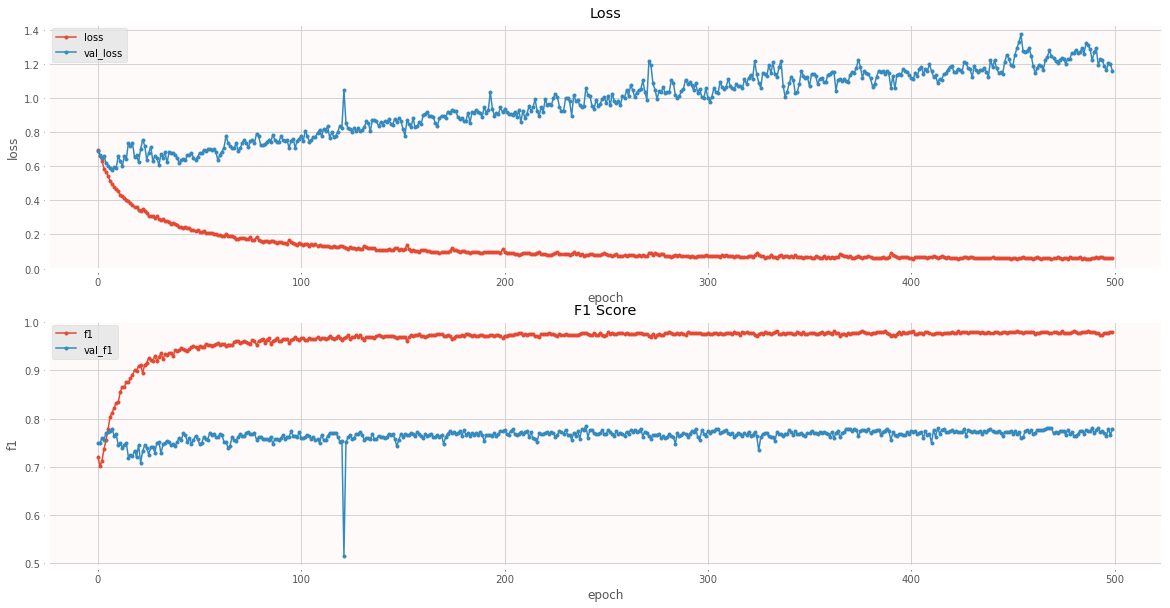

In [38]:
for i in range(len(history_list)):
    plot_history(history_list[i])

In [39]:
# plt.savefig(r'C:\Users\YangWang\Desktop\Text_Classifier_for_UtaPass_and_KKBOX\image\cumulative_percentage.png', 
#             bbox_inches='tight')